### Đây là Dataset bất động sản cho thuê trên trang web AirBnb
### Dataset này được crawled từ trang web nên dữ liệu lỗi khá nhiều cùng với dung lượng ~2Gb tương đối lớn thích hợp để luyện tập processing  

### Để tận dụng resource của máy, ta dùng Spark xử lý dữ liệu

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master('spark://spark-master-1:7077') \
    .appName("AirBnb Analysis") \
    .config('spark.executor.memory', '16g') \
    .config('spark.driver.memory', '16g') \
    .getOrCreate()
spark

In [2]:
sc = spark.sparkContext

In [3]:
import pandas as pd

# **EDA**

In [4]:
df = spark.read.option("delimiter", ";").csv("airbnb-listings.csv", header=True)
originDF = df

In [5]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Listing Url: string (nullable = true)
 |-- Scrape ID: string (nullable = true)
 |-- Last Scraped: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Space: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Experiences Offered: string (nullable = true)
 |-- Neighborhood Overview: string (nullable = true)
 |-- Notes: string (nullable = true)
 |-- Transit: string (nullable = true)
 |-- Access: string (nullable = true)
 |-- Interaction: string (nullable = true)
 |-- House Rules: string (nullable = true)
 |-- Thumbnail Url: string (nullable = true)
 |-- Medium Url: string (nullable = true)
 |-- Picture Url: string (nullable = true)
 |-- XL Picture Url: string (nullable = true)
 |-- Host ID: string (nullable = true)
 |-- Host URL: string (nullable = true)
 |-- Host Name: string (nullable = true)
 |-- Host Since: string (nullable = true)
 |-- Host Location: string (nullable

### Khá nhiều cột đáng lẽ giá trị là kiểu Int nhưng lại detect là string như (bathrooms, bedrooms), chứng tỏ data chưa sạch

In [6]:
describe_df = df.describe(df.columns)

In [7]:
pd.set_option('display.max_rows', None)
describe_df.toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,914139,9861477.119835062,5401900.739531201,\t(URL HIDDEN),"７３９号弥敦道, 旺角, Kowloon, Hong Kong"""
Listing Url,616004,8573.375,12873.230929085807,,"由于我们长期不在家,所以想把我们可爱的小屋与其它喜欢airbnb短期旅行的人一同分享,一起感..."
Scrape ID,610372,1.6440207173571863E13,7.829924154603344E12,,"我们的房间都很温馨整洁,希望给带来好的睡眠。我们不吸烟,家里没有宠物"
Last Scraped,510310,94.56318264387258,15.548644969382437,,"我们很有规律的生活,也希望这样的朋友到来,互相遵守与尊重对方的生活。同时,如果需要各大节日,..."
Name,626141,10058.497663898033,86651.40752018221,"Italy, Mexico, Hawaii.",｜SWSW ｜ Cozy Townhome Apt 858 sq ft
Summary,612549,937.2052696861476,9007.448927630337,London,ﾙｰﾑ中に付き ｰ ﾄｲﾚｼｬﾜｰ ｰ ﾃﾚﾋﾞ ｰ ｴｱｺﾝ ｰ ｽﾘｯﾊﾟ ｰ 歯磨き粉...
Space,454109,5297.812223284515,16633.259169787234,- A Bedroom - A Living room - A Kitchen - A ...,ﾘｿﾞｰﾄｽﾀｲﾙのﾕﾆｯﾄ
Description,628017,23.135346784958063,99.35272721163703,One second bedroom consists of two adjust...,ﾙｰﾑ中に付き ﾄｲﾚｼｬﾜｰ ﾃﾚﾋﾞ ｴｱｺﾝ ...
Experiences Offered,628698,22.831679829754073,98.40106642825579,One individual shower room,"香港, Hong Kong"


In [8]:
import re
url_cols = list(filter(lambda c: re.search('url', c.lower()) != None, df.columns))
url_cols

['Listing Url',
 'Thumbnail Url',
 'Medium Url',
 'Picture Url',
 'XL Picture Url',
 'Host URL',
 'Host Thumbnail Url',
 'Host Picture Url']

In [9]:
df = df.drop(*url_cols)

In [10]:
from pyspark.sql.functions import isnan, col

### Dựa vào kết quả statistics phía trên, ta thấy giá trị Country bị thiếu khá nhiều
### Tuy nhiên Country lại là giá trị cốt lõi quan trọng mà ta cũng không thể fill value cho các giá trị missing vì số lượng missing quá lớn. 
### Chúng ta đành chấp nhận filter lại dataset

In [11]:
df = df.filter(df.City.isNotNull() & df.Country.isNotNull())

### Vì dataset được crawl từ web nên có khả năng dữ liệu bị parsed sai dẫn đến kiểu dữ liệu Int bị detect là String như ở đầu notebook

In [12]:
df.select('Bathrooms', 'Bedrooms', 'Beds', 'Price').head(25)

[Row(Bathrooms='2016-11-27', Bedrooms='89', Beds='9', Price='10'),
 Row(Bathrooms='2017-01-19', Bedrooms='99', Beds='9', Price='10'),
 Row(Bathrooms='1.0', Bedrooms='2', Beds='2', Price='125'),
 Row(Bathrooms='1.0', Bedrooms='2', Beds='4', Price='130'),
 Row(Bathrooms='1.0', Bedrooms='0', Beds='1', Price='80'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='150'),
 Row(Bathrooms='1.5', Bedrooms='2', Beds='2', Price='144'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='75'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='59'),
 Row(Bathrooms='2.0', Bedrooms='4', Beds='4', Price='200'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='134'),
 Row(Bathrooms='2017-03-27', Bedrooms='100', Beds='10', Price='10'),
 Row(Bathrooms='1.5', Bedrooms='0', Beds='1', Price='99'),
 Row(Bathrooms='2016-11-29', Bedrooms='90', Beds='9', Price='9'),
 Row(Bathrooms='1.0', Bedrooms='2', Beds='2', Price='144'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='114'),
 Row(Bathrooms=

In [13]:
df.select('Bathrooms', 'Bedrooms', 'Beds', 'Price').tail(25)

[Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='40'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='30'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='16'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='10'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='15'),
 Row(Bathrooms='1.0', Bedrooms='2', Beds='2', Price='59'),
 Row(Bathrooms='1.0', Bedrooms='2', Beds='2', Price='70'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='35'),
 Row(Bathrooms='1.0', Bedrooms='2', Beds='1', Price='35'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='49'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='30'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='30'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='2', Price='64'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='1', Price='50'),
 Row(Bathrooms='2016-06-30', Bedrooms='97', Beds='10', Price='10'),
 Row(Bathrooms='1.0', Bedrooms='1', Beds='2', Price='35'),
 Row(Bathrooms='2017-04-07', Bedrooms='93', Bed

### Dữ liệu Bathrooms có giá trị là Date, không có cách nào để replace giá trị này
### Nên ta filter lại dataset

In [14]:
df = df.filter((df['Price']).cast('int').isNotNull() & df['Bedrooms'].cast('int').isNotNull() & df['Beds'].cast('int').isNotNull() & df['Bathrooms'].cast('int').isNotNull())

In [15]:
df.count()

350316

In [16]:
originDF.filter(df.Price.isNull()).count()

451943

### Thống kê lại dataset lần nữa để check xem các cột giá trị đã phần nào hợp lệ chưa

In [17]:
describe_df = df.describe(df.columns)

In [18]:
pd.set_option('display.max_rows', None)
describe_df.toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,350316,1.0362792807545187E7,5239413.586654871,10000061,9999980
Scrape ID,350316,2.0169352519394547E13,3.248488470468497E9,20151011232639,20170615002708
Last Scraped,350316,None,None,2015-10-12,2017-06-15
Name,349977,76458.8,233941.77858415068,"! ! ! Coliving in Brooklyn, New York /1",｜SWSW ｜ Cozy Townhome Apt 858 sq ft
Summary,341270,83.5,108.74588114805391,!,ﾙｰﾑ中に付き ｰ ﾄｲﾚｼｬﾜｰ ｰ ﾃﾚﾋﾞ ｰ ｴｱｺﾝ ｰ ｽﾘｯﾊﾟ ｰ 歯磨き粉...
Space,227365,10756.142857142857,28331.604857641294,! Ideal for two friends ! Located in an old Pa...,｡There are two queen beds: one memory foam bed...
Description,350185,116.5,161.92745289171938,"bathroom with tub, www, a guitar and of cours...",ﾙｰﾑ中に付き ﾄｲﾚｼｬﾜｰ ﾃﾚﾋﾞ ｴｱｺﾝ ...
Experiences Offered,350316,None,None,"or the countless bars, flamenco ta""",social
Neighborhood Overview,192224,3.75,3.774917217635375,!!!YOU CAN'T BEAT THIS AMAZING FULTON MARKET D...,｡Walking distance to restaurants and Central P...


### Sau khi xử lý thì hầu như các cột đều có giá trị đúng kiểu dữ liệu của nó. Tiếp đến ta visualize để phát hiện bất thường cũng như quan hệ giữa các biến

## Room Type & Property

In [19]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(13,7)})

<AxesSubplot:ylabel='count'>

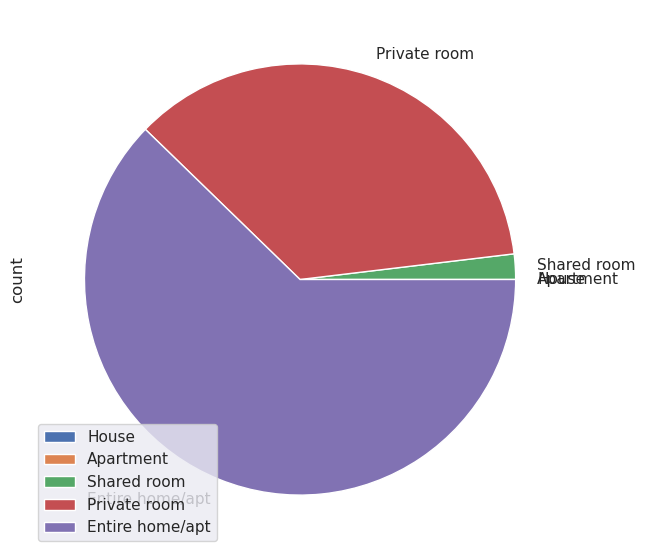

In [20]:
groupField = 'Room Type'
df.groupBy([groupField]).count().sort('count').toPandas().set_index(groupField).plot(kind='pie', y='count')

#### House và Apartment chiếm tỉ lệ quá bé chỉ có vài case, nếu ép mô hình học các outlier này sẽ dẫn đến performance kém cùng với việc không mang lại ý nghĩa vì số case này quá ít
#### Filter loại bỏ 2 loại Room Type này

In [21]:
df = df.filter(df['Room Type'].isin(['Shared room', 'Private room', 'Entire home/apt']))

<AxesSubplot:ylabel='count'>

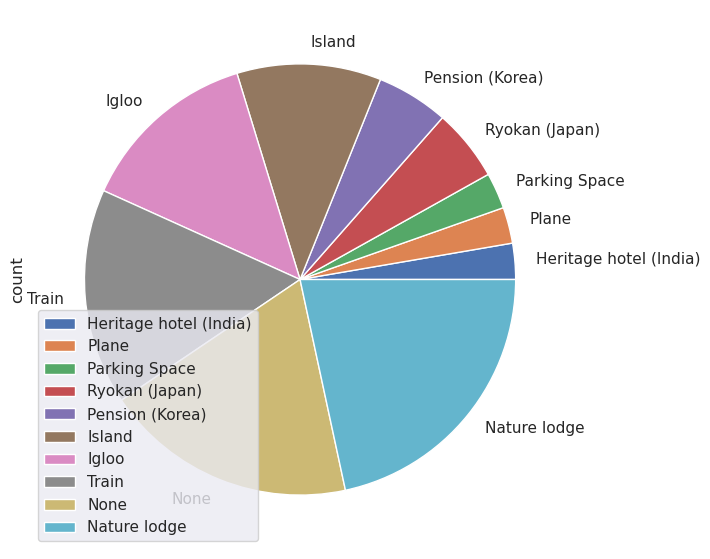

In [22]:
groupField = 'Property Type'
df.groupBy([groupField]).count().sort('count').toPandas().set_index(groupField)[:10].plot(kind='pie', y='count')

## Country

<AxesSubplot:xlabel='Country'>

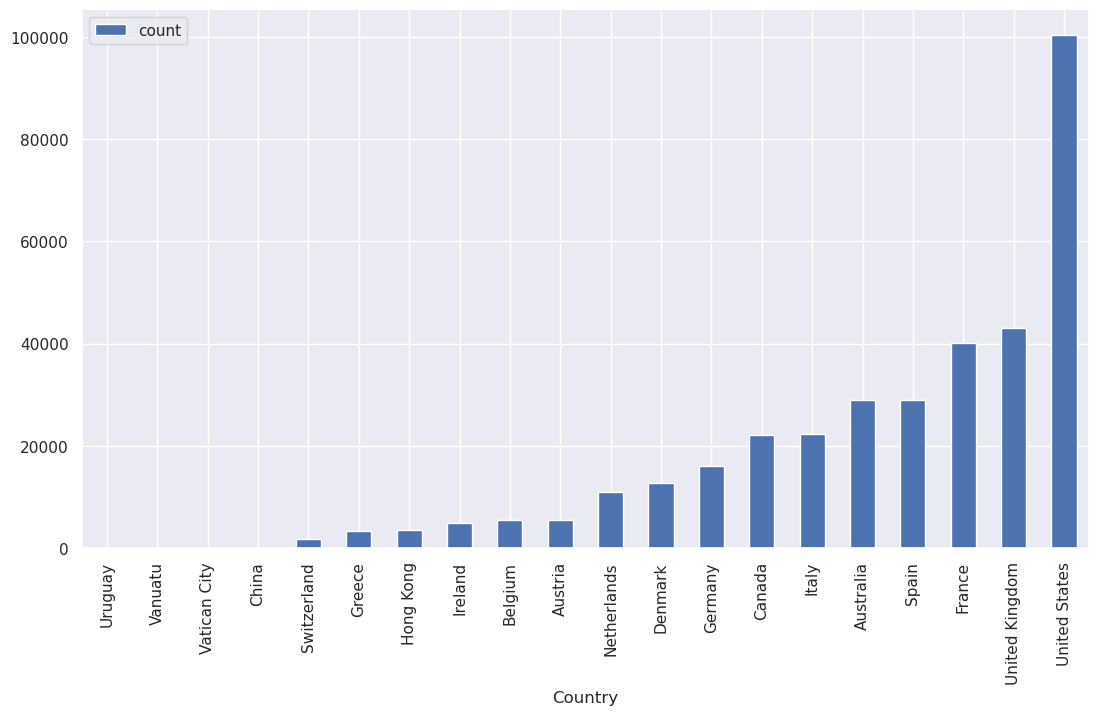

In [23]:
groupField = 'Country'
df.groupBy([groupField]).count().sort('count').toPandas().set_index(groupField).plot(kind='bar', y='count')

## Price

In [24]:
df = df.withColumn('Price', df.Price.cast('int'))

<AxesSubplot:ylabel='Density'>

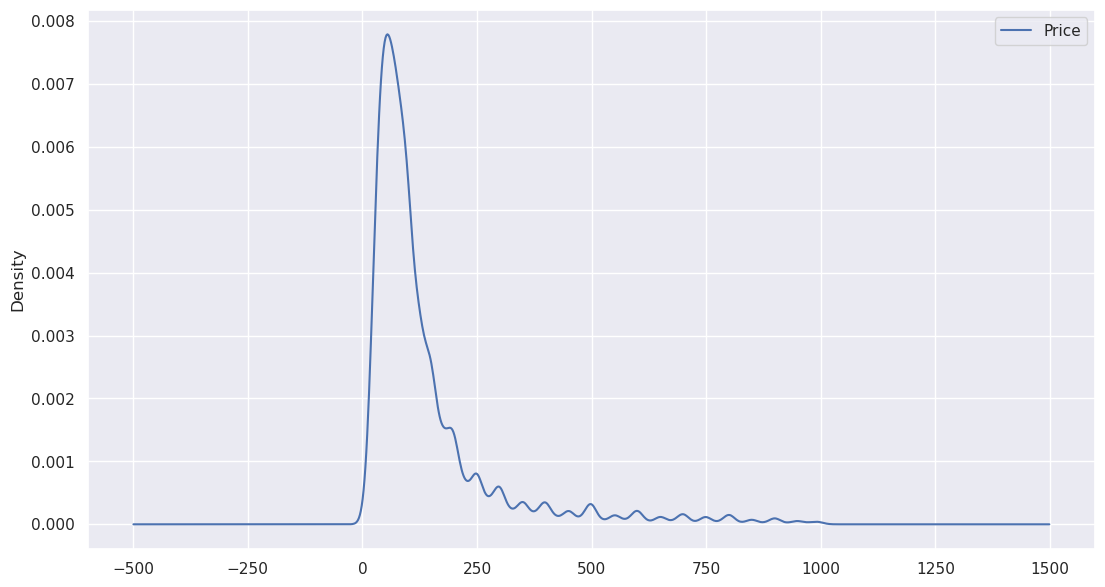

In [25]:
df.select('Price').toPandas().plot(kind='density')

<AxesSubplot:>

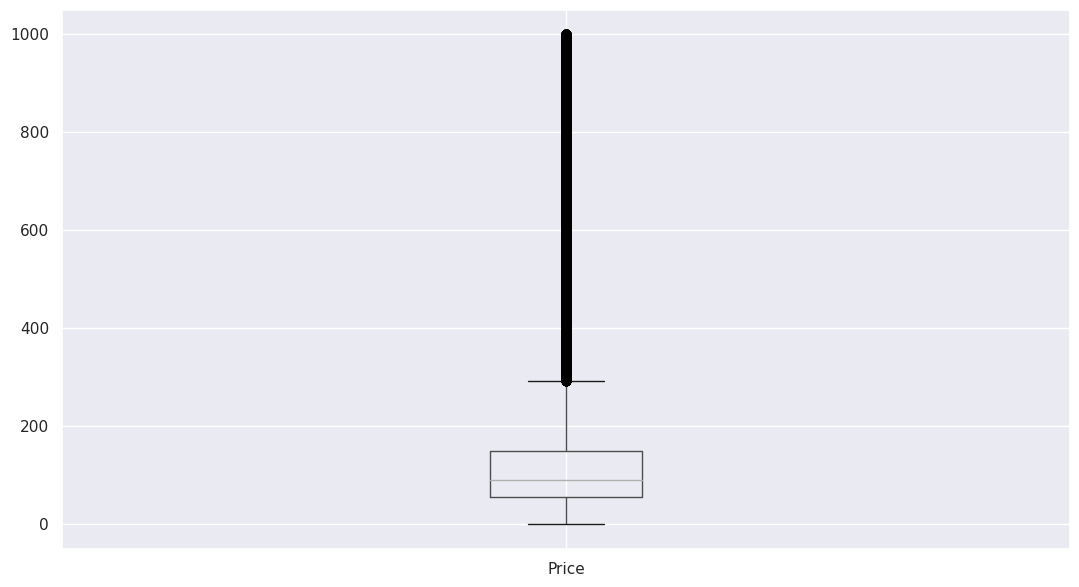

In [26]:
df.select('Price').toPandas().boxplot()

#### Price có outliers khá nhiều, có thể outliers này có ý nghĩa cùng với một vài column khác.
#### Ta đi tìm nguyên nhân để đưa ra phương pháp xử lý

### Price Distribution By Country

Country
Australia         [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Austria           [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Belgium           [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Canada            [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
China             [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Denmark           [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
France            [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Germany           [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Greece            [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Hong Kong         [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Ireland           [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Italy             [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Netherlands       [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Spain             [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Switzerland       [[AxesSubplot(0.125,0.

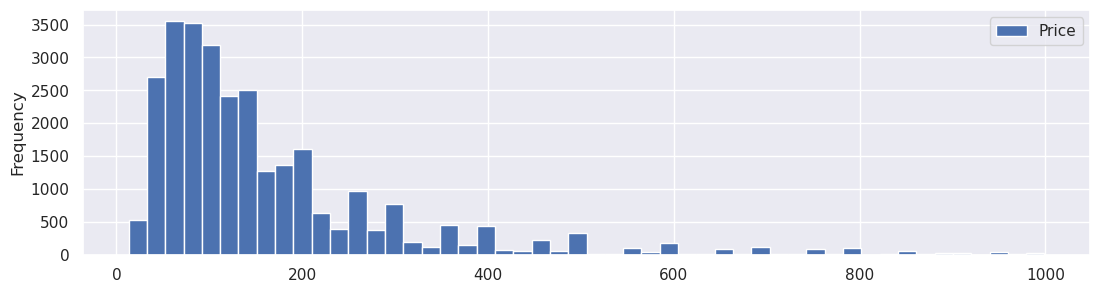

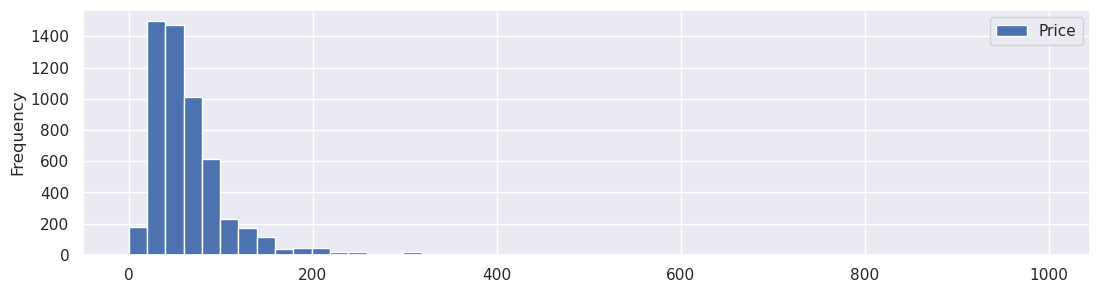

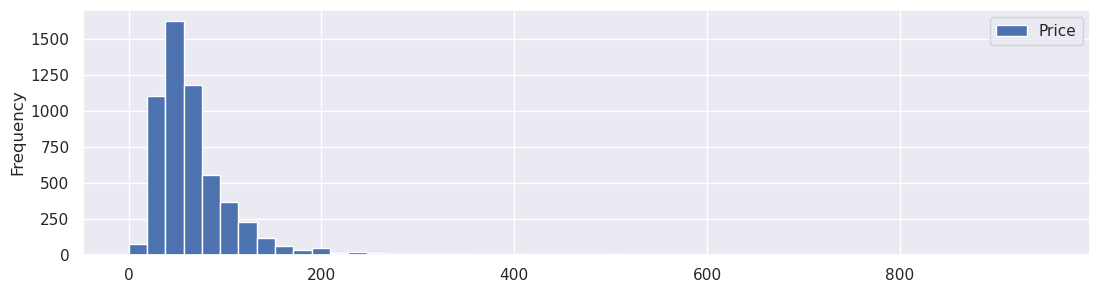

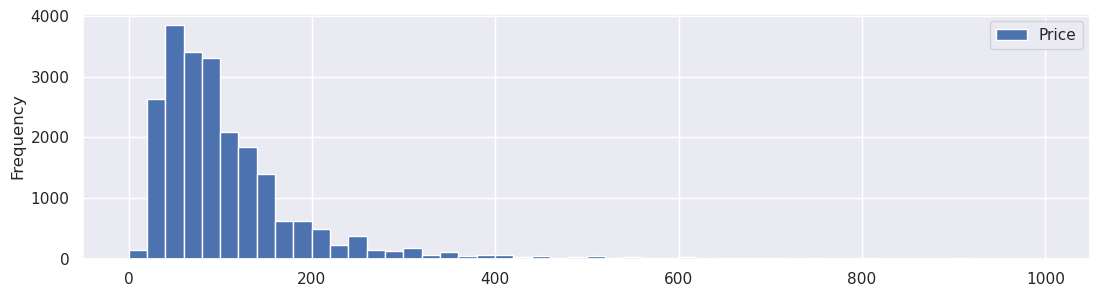

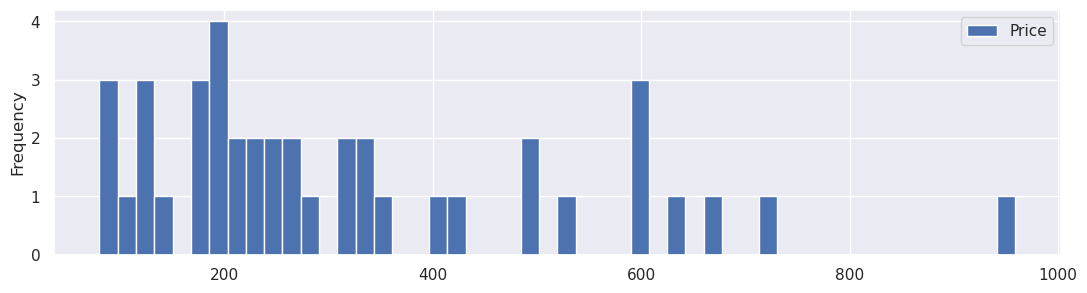

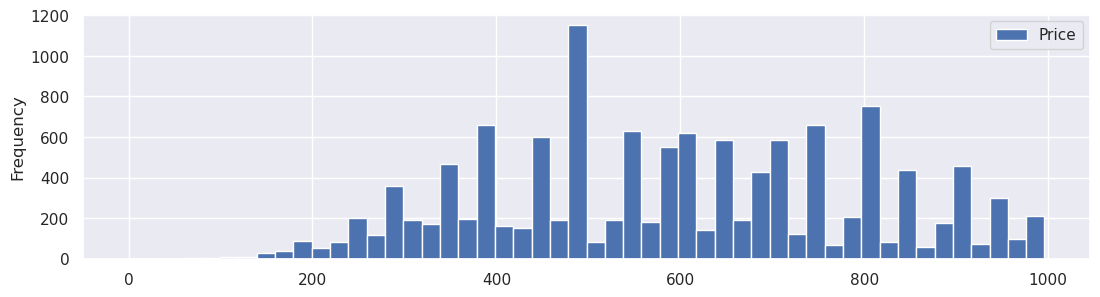

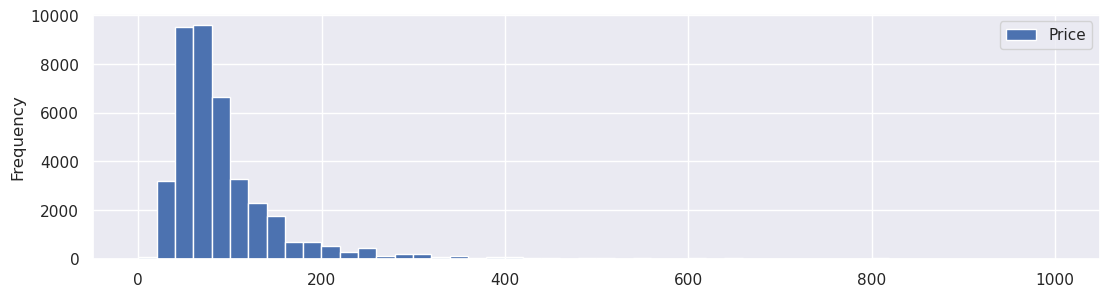

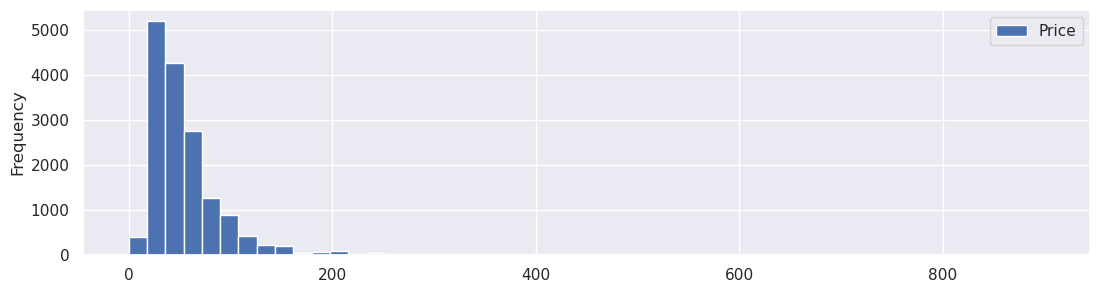

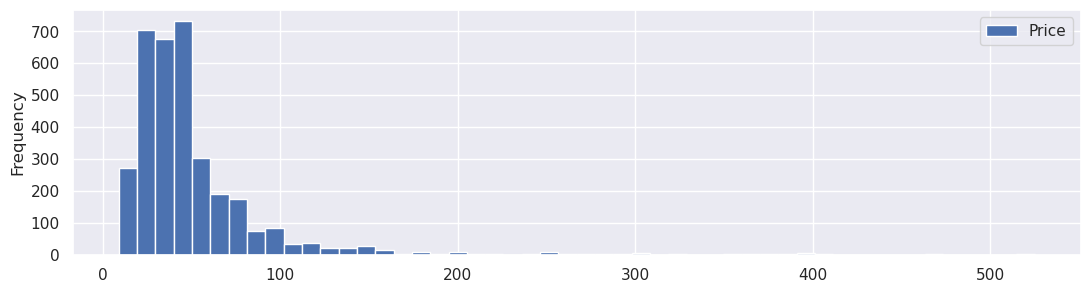

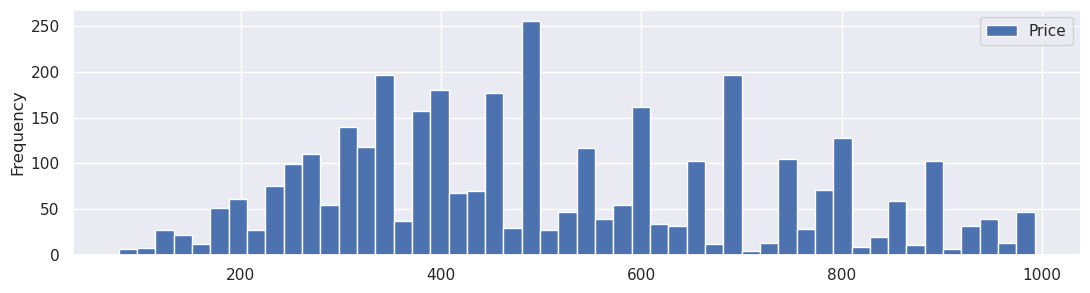

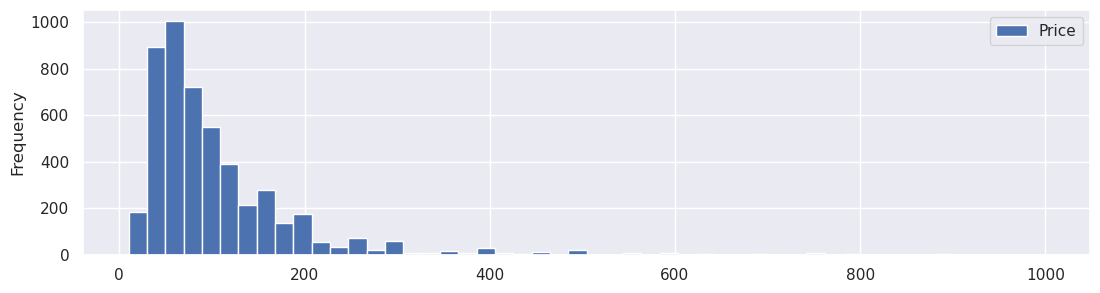

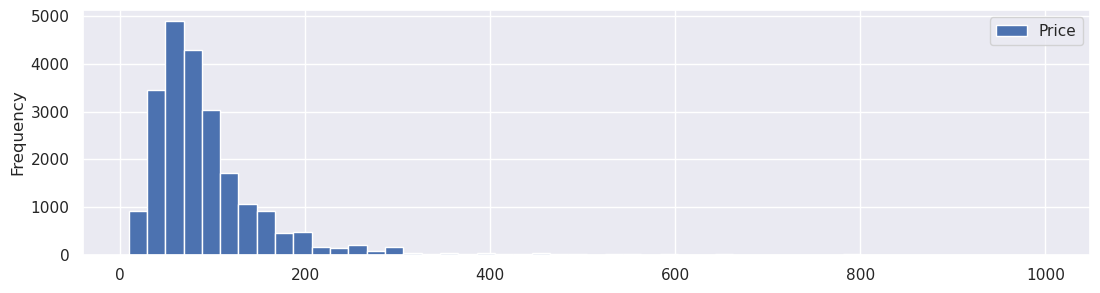

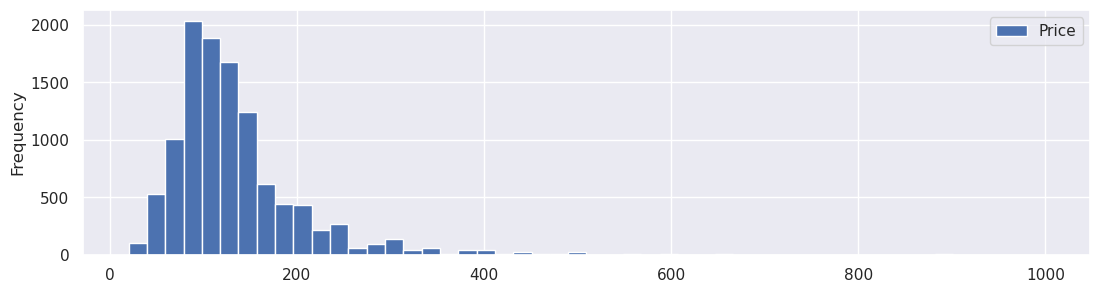

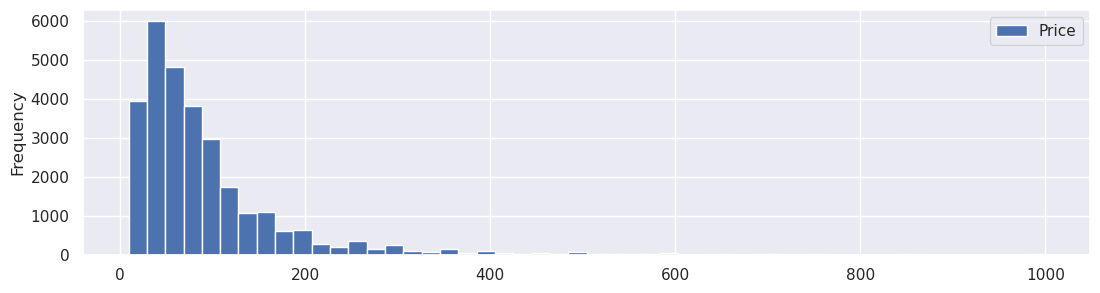

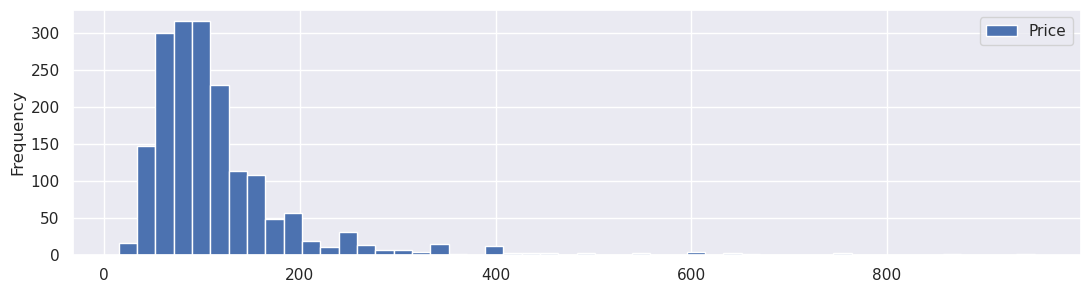

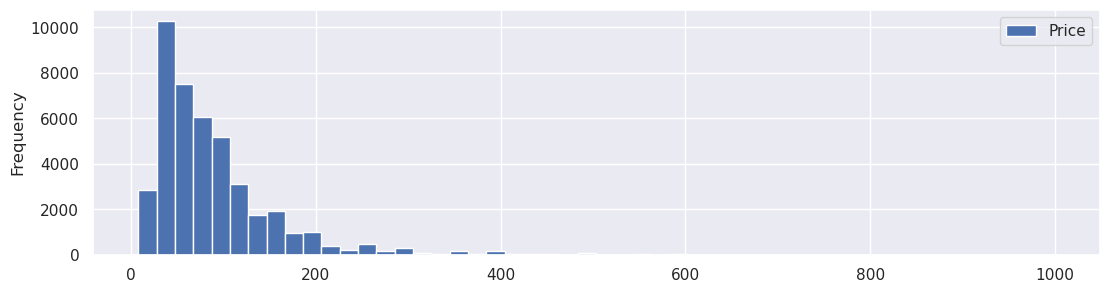

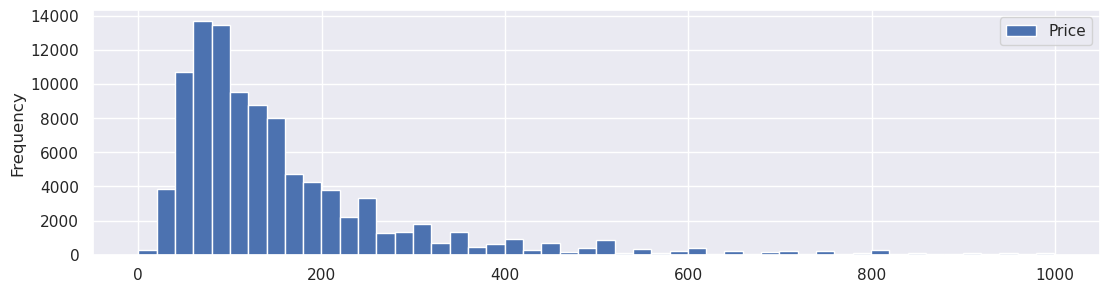

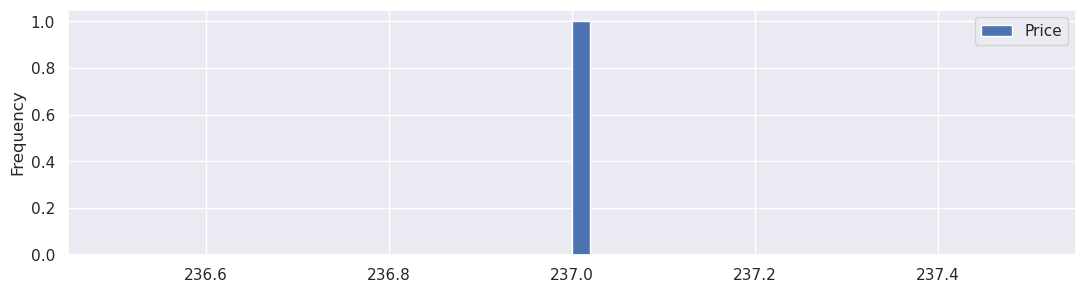

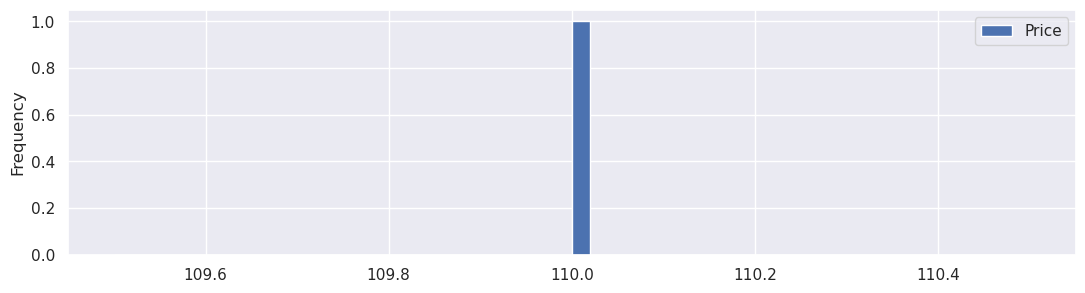

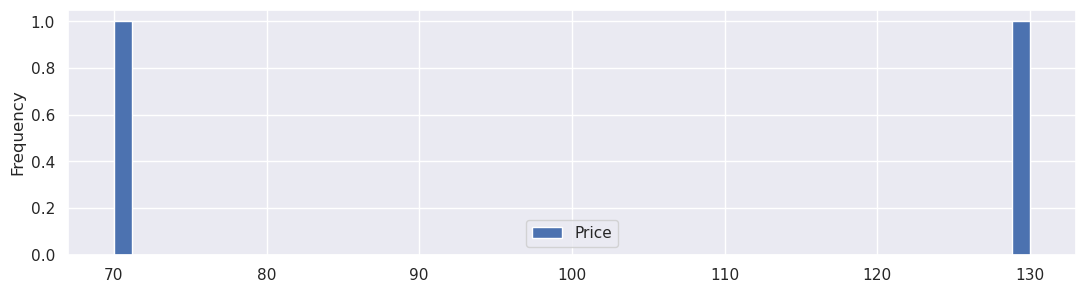

In [27]:
df.select('Price', 'Country').toPandas().groupby('Country').plot(kind='hist', bins=50, subplots=True, layout=(2, 1), legend=True)

### Price Distribution by Room Type

Room Type
Entire home/apt    [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Private room       [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Shared room        [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
dtype: object

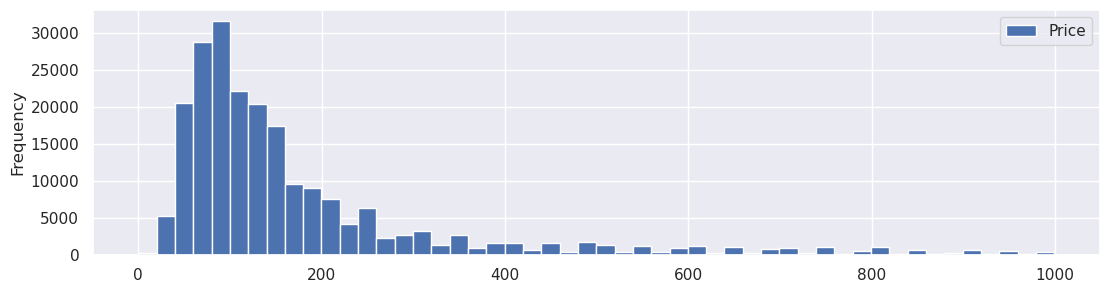

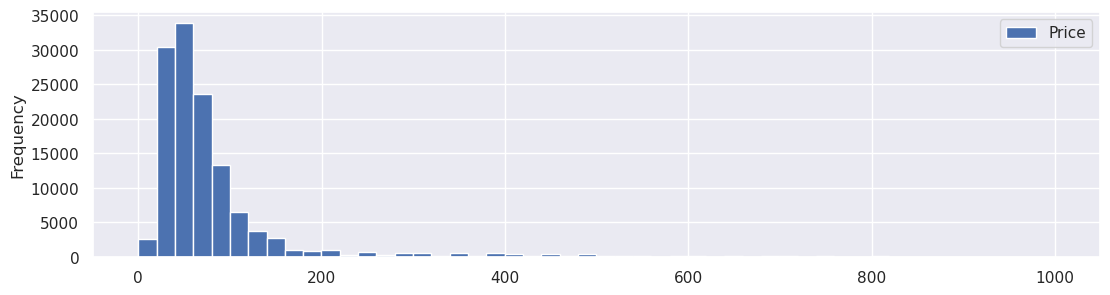

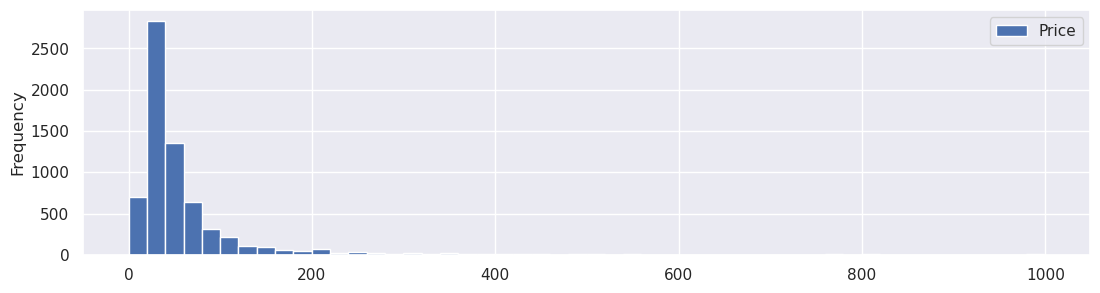

In [28]:
df.select('Price', 'Room Type').toPandas().groupby('Room Type').plot(kind='hist', bins=50, subplots=True, layout=(2, 1), legend=True)

### Bedrooms & Beds & Bathrooms

In [29]:
df = df.withColumn('Bedrooms', df.Bedrooms.cast('int'))

<AxesSubplot:ylabel='Frequency'>

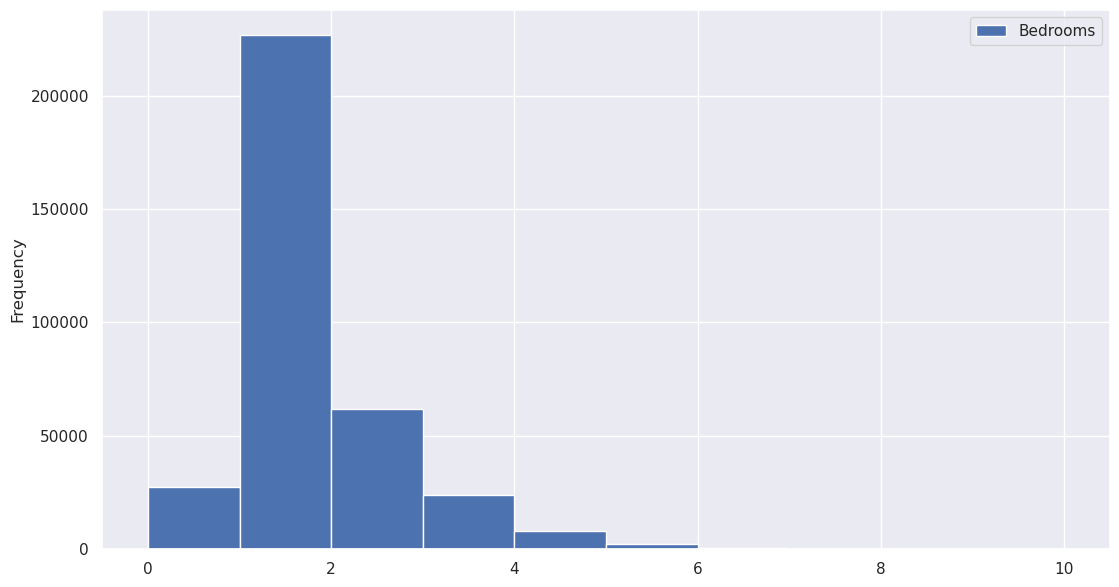

In [30]:
df.select('Bedrooms').toPandas().plot(kind='hist')

Room Type
Entire home/apt    [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Private room       [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Shared room        [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
dtype: object

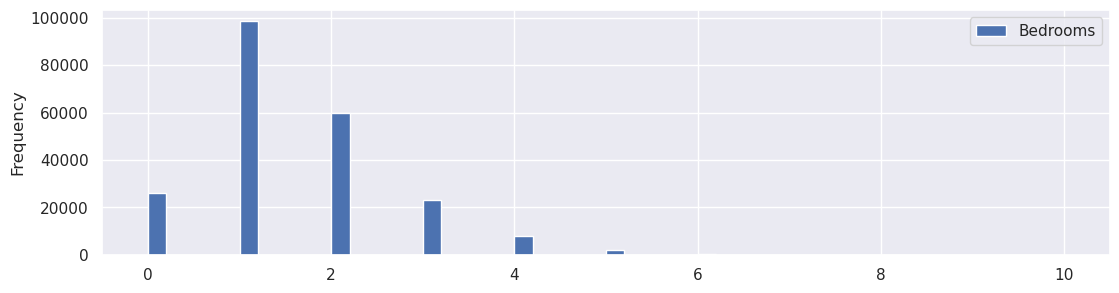

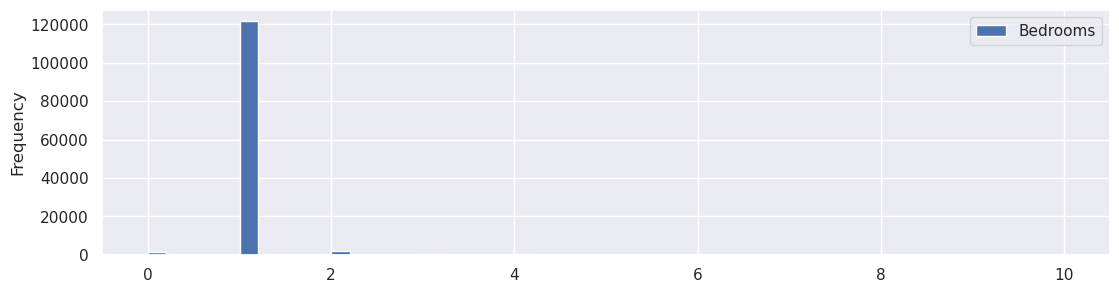

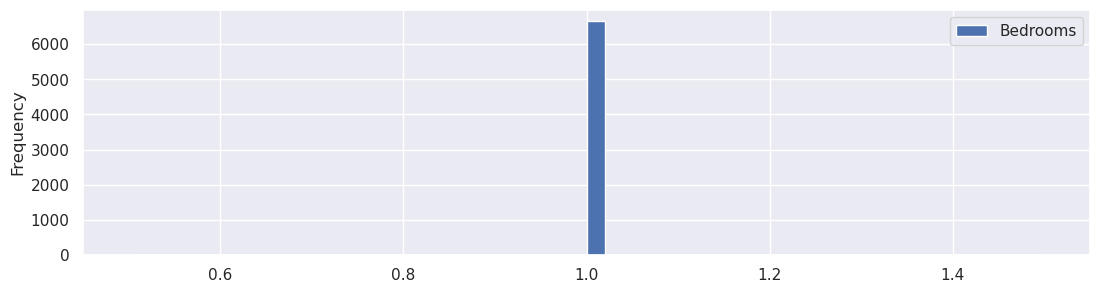

In [31]:
df.select('Room Type', 'Bedrooms').toPandas().groupby('Room Type').plot(kind='hist', bins=50, subplots=True, layout=(2, 1), legend=True)

Room Type
Entire home/apt    [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Private room       [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Shared room        [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
dtype: object

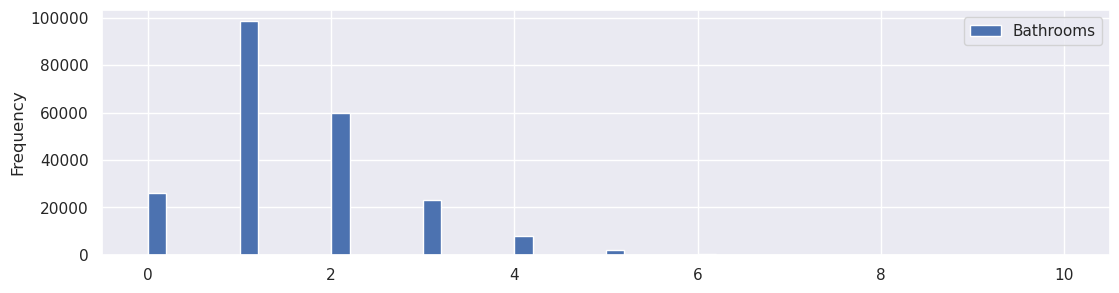

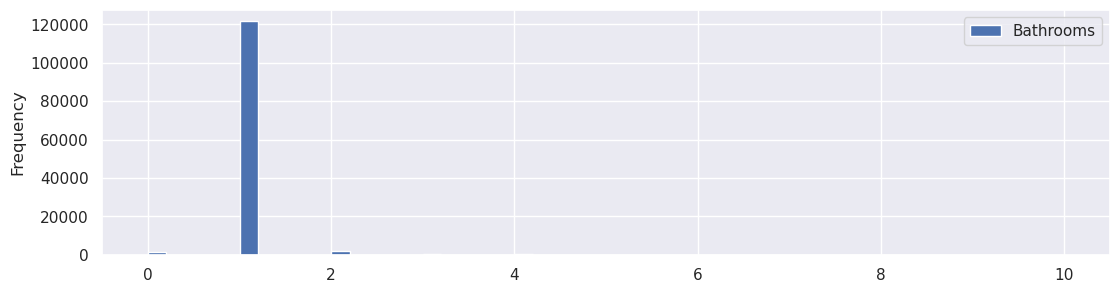

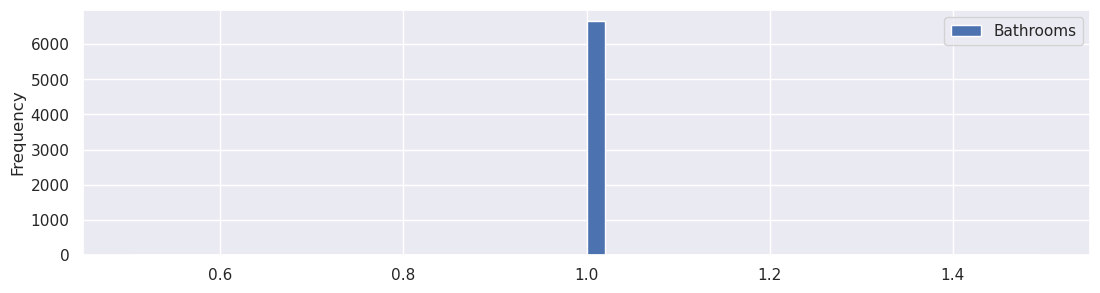

In [32]:
df = df.withColumn('Bathrooms', df.Bedrooms.cast('int'))
df.select('Room Type', 'Bathrooms').toPandas().groupby('Room Type').plot(kind='hist', bins=50, subplots=True, layout=(2, 1), legend=True)

<AxesSubplot:xlabel='Bedrooms', ylabel='Bathrooms'>

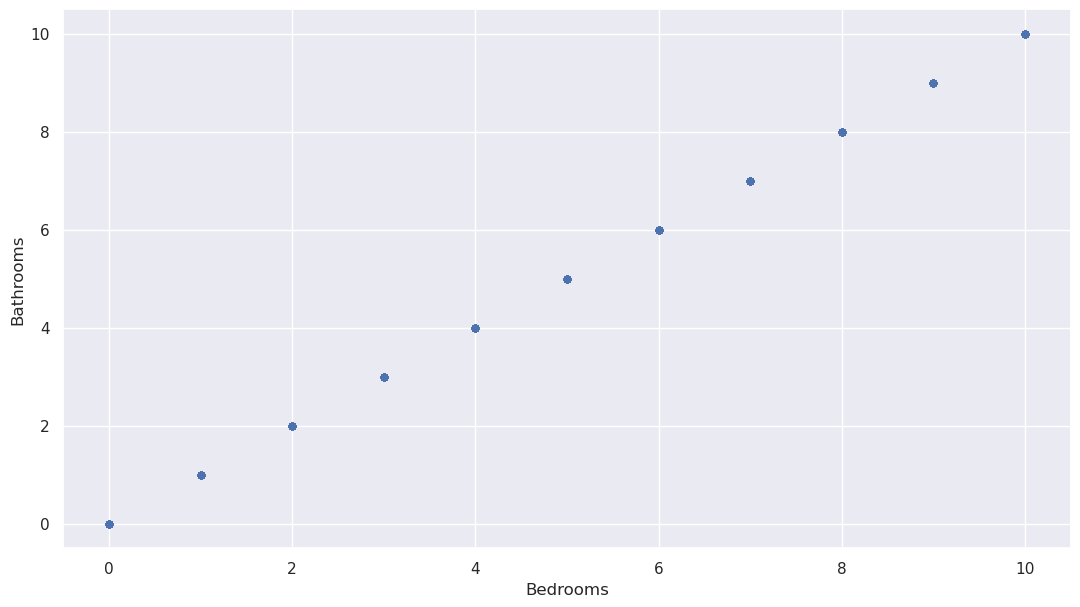

In [33]:
df.select('Bedrooms', 'Bathrooms').toPandas().plot(kind='scatter', x='Bedrooms', y='Bathrooms', legend=True)

### Số phòng ngủ và phòng tắm tỷ lệ thuận với nhau, ta có thể giữ lại 1 column cho quá trình học máy

### Bedrooms & Beds

<AxesSubplot:xlabel='Bedrooms', ylabel='Beds'>

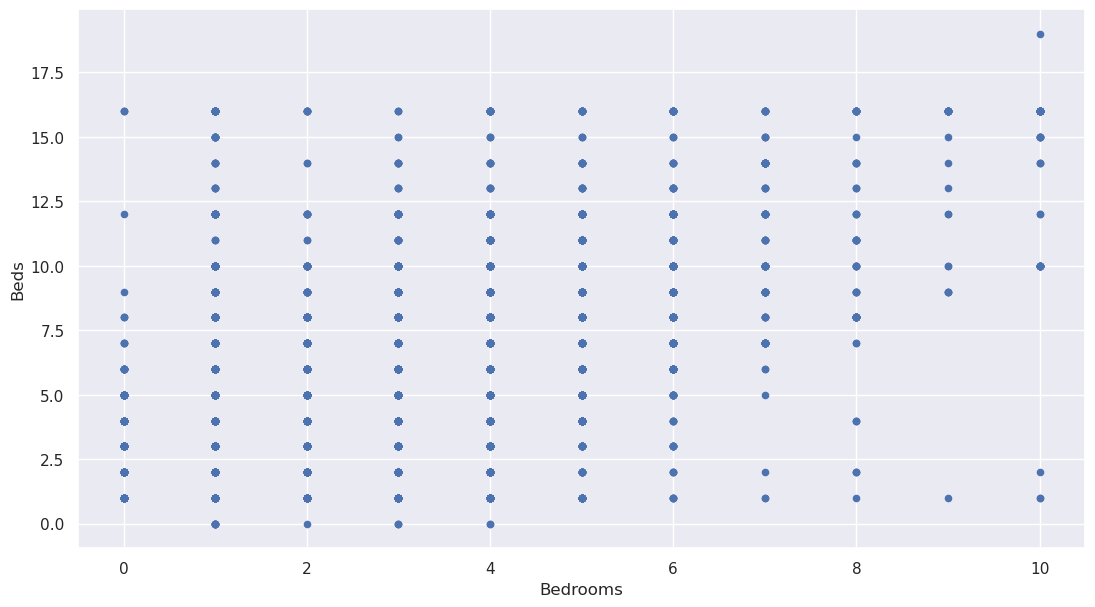

In [34]:
df = df.withColumn('Beds', df.Beds.cast('int'))
df.select('Bedrooms', 'Beds').toPandas().plot(kind='scatter', x='Bedrooms', y='Beds', legend=True)

In [35]:
bedrooms_beds = df.select('Name', 'Room Type', 'Bedrooms', 'Bathrooms', 'Beds', 'Accommodates', 'Bed Type', 'Square Feet', 'City', 'Country').where((df.Bedrooms < 2) & (df.Beds > 6))

In [36]:
bedrooms_beds.describe('Bedrooms', 'Beds', 'Accommodates', 'Bathrooms', 'Square Feet').show()

+-------+-------------------+------------------+-----------------+-------------------+-----------------+
|summary|           Bedrooms|              Beds|     Accommodates|          Bathrooms|      Square Feet|
+-------+-------------------+------------------+-----------------+-------------------+-----------------+
|  count|                519|               519|              519|                519|               12|
|   mean|  0.976878612716763|10.059730250481696| 7.59344894026975|  0.976878612716763|            734.0|
| stddev|0.15043401401474704|2.8424350463522976|4.691900876483121|0.15043401401474704|963.4763760843996|
|    min|                  0|                 7|                1|                  0|                0|
|    max|                  1|                16|                9|                  1|              861|
+-------+-------------------+------------------+-----------------+-------------------+-----------------+



In [37]:
df.describe('Bedrooms', 'Beds', 'Accommodates', 'Bathrooms', 'Square Feet').show()

+-------+------------------+------------------+-----------------+------------------+-----------------+
|summary|          Bedrooms|              Beds|     Accommodates|         Bathrooms|      Square Feet|
+-------+------------------+------------------+-----------------+------------------+-----------------+
|  count|            350305|            350305|           350251|            350305|             6122|
|   mean|1.3364268280498424|1.8580522687372432|3.191274257603833|1.3364268280498424|594.4072198627899|
| stddev|0.8852428147753297|1.3920258385724245|1.975846856186924|0.8852428147753297|1694.287414751063|
|    min|                 0|                 0|                1|                 0|                0|
|    max|                10|                19|                9|                10|              990|
+-------+------------------+------------------+-----------------+------------------+-----------------+



<AxesSubplot:>

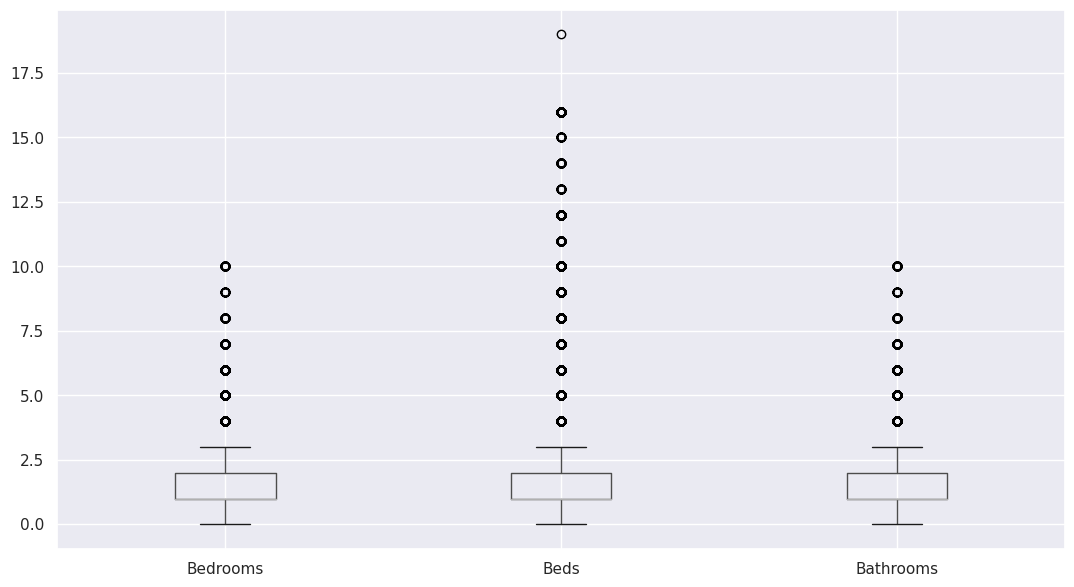

In [38]:
df.select('Bedrooms', 'Beds', 'Accommodates', 'Bathrooms').toPandas().boxplot()

In [39]:
bedrooms_beds.show(truncate=False)

+--------------------------------------------------+---------------+--------+---------+----+------------+--------+-----------+---------------------+--------------+
|Name                                              |Room Type      |Bedrooms|Bathrooms|Beds|Accommodates|Bed Type|Square Feet|City                 |Country       |
+--------------------------------------------------+---------------+--------+---------+----+------------+--------+-----------+---------------------+--------------+
|TOP 5 Airbnb: STEPS FROM STAPLES CENTER ! USC     |Shared room    |1       |1        |8   |3           |Real Bed|null       |Los Angeles          |United States |
|TOP 5 Airbnb: NEAR DOWNTOWN ! CLOSE TO ANYWHERE ! |Shared room    |1       |1        |8   |2           |Real Bed|null       |Los Angeles          |United States |
|TOP 5 Airbnb: 2 MIN TO STAPLES CENTER ! DOWNTOWN !|Shared room    |1       |1        |8   |4           |Real Bed|null       |Los Angeles          |United States |
|9 Bed Mixed Dor

<AxesSubplot:xlabel='Room Type'>

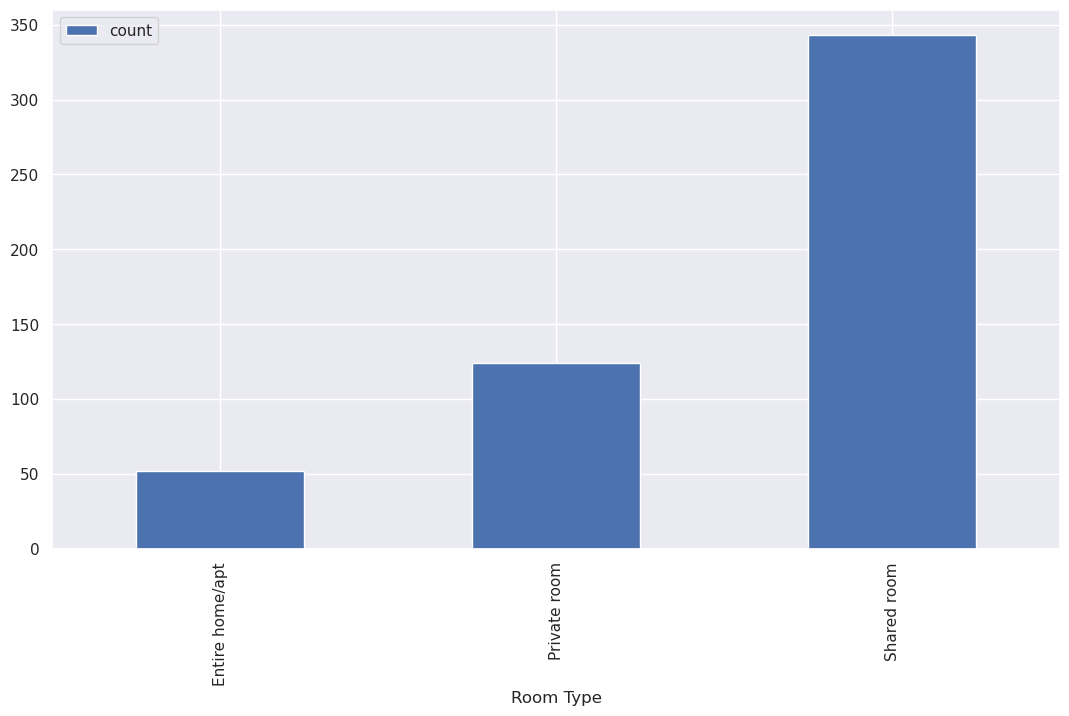

In [40]:
groupField = 'Room Type'
bedrooms_beds.groupBy([groupField]).count().sort('count').toPandas().set_index(groupField).plot(kind='bar', y='count')

<AxesSubplot:xlabel='Bed Type'>

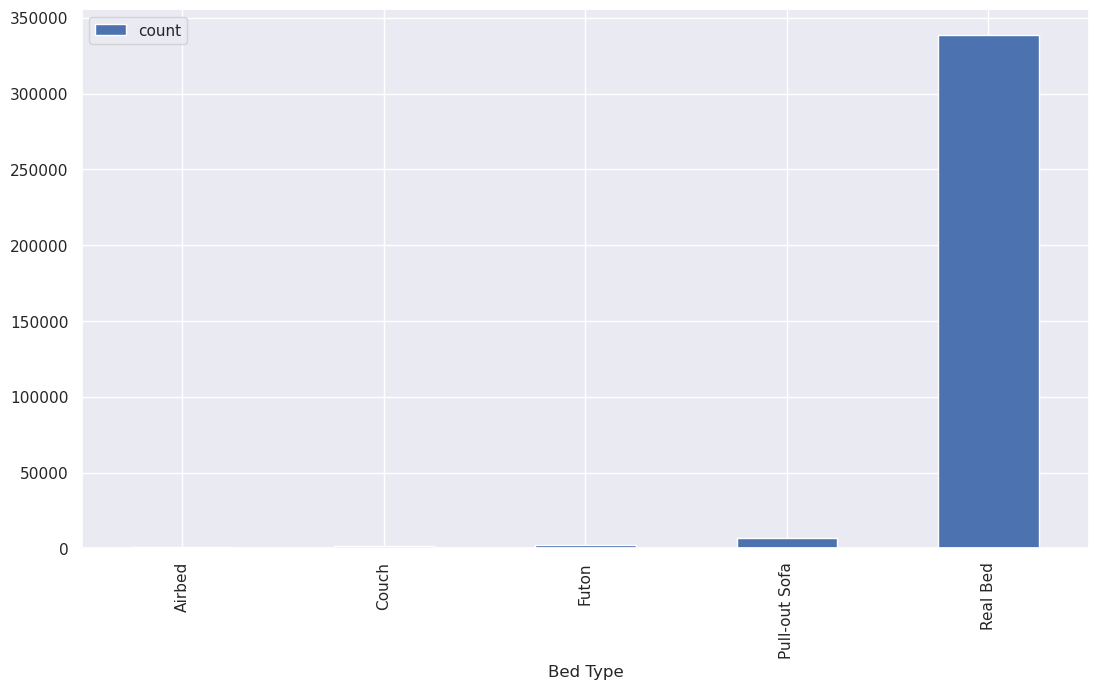

In [41]:
groupField = 'Bed Type'
df.groupBy([groupField]).count().sort('count').toPandas().set_index(groupField).plot(kind='bar', y='count')

Bed Type
Airbed           [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Couch            [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Futon            [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Pull-out Sofa    [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
Real Bed         [[AxesSubplot(0.125,0.53;0.775x0.35)], [AxesSu...
dtype: object

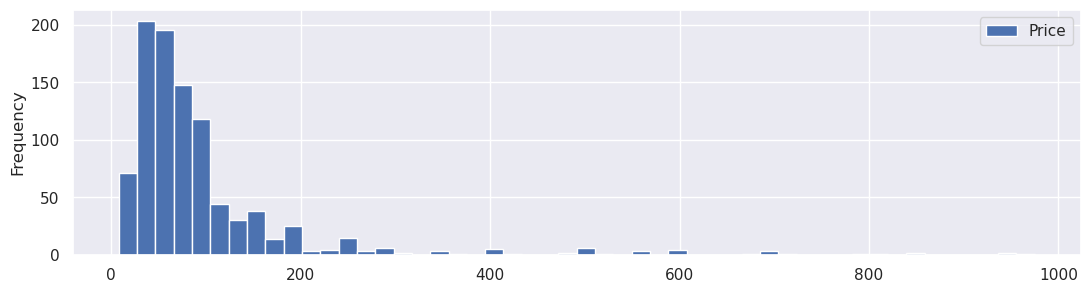

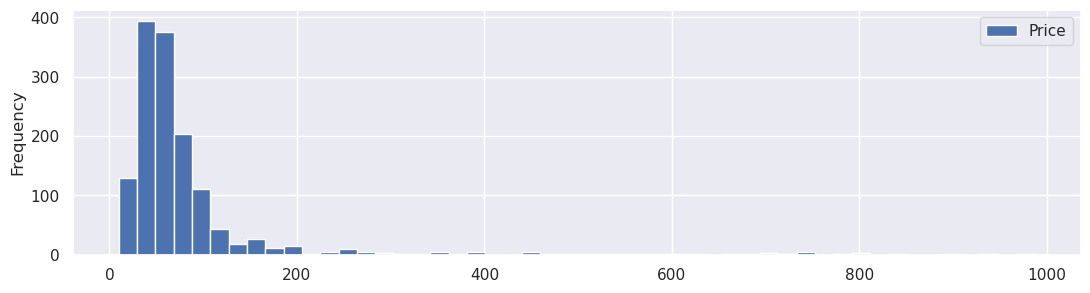

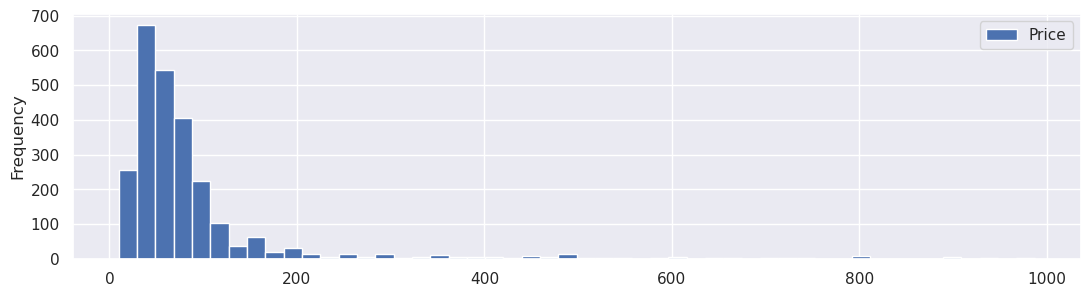

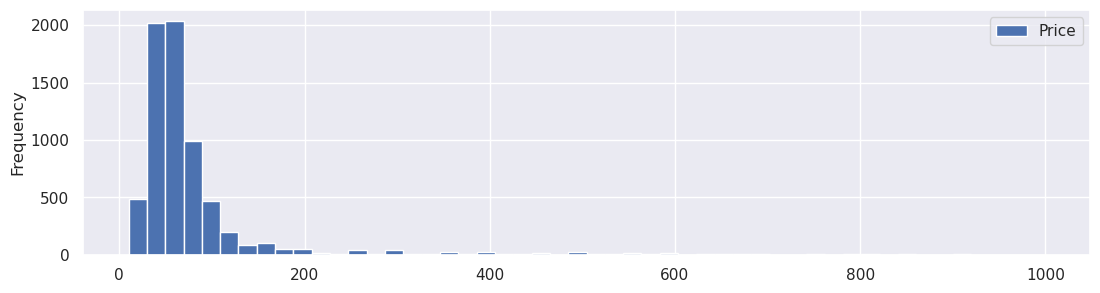

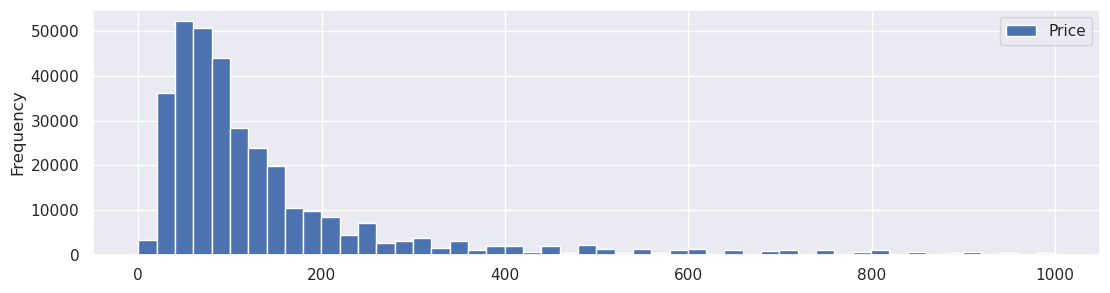

In [42]:
df.select('Bed Type', 'Price').toPandas().groupby('Bed Type').plot(kind='hist', bins=50, subplots=True, layout=(2, 1), legend=True)

<AxesSubplot:xlabel='Bedrooms', ylabel='Price'>

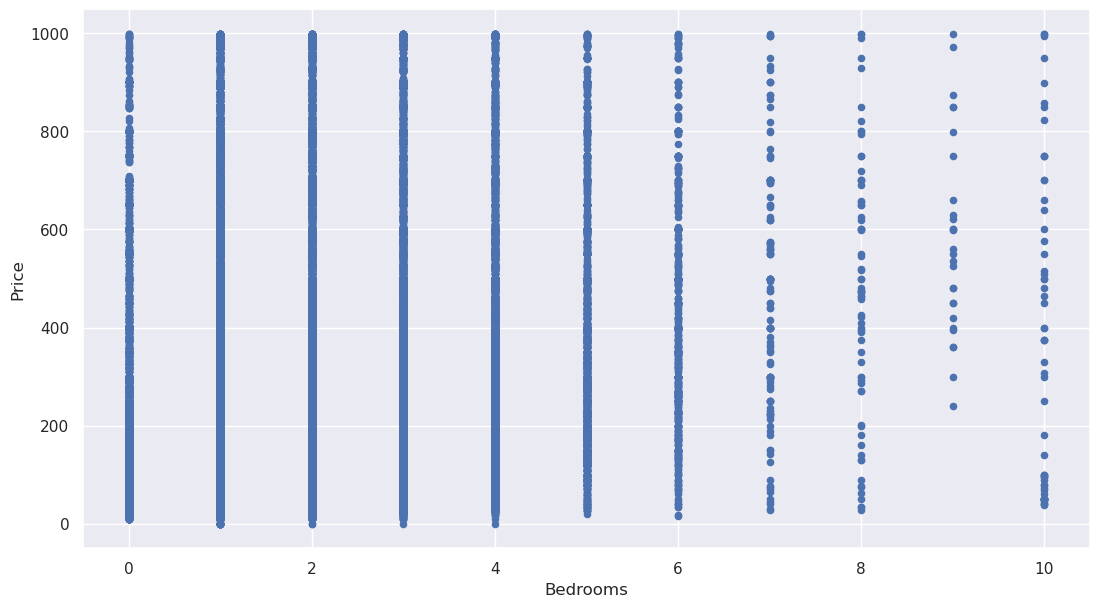

In [43]:
df.select('Price', 'Bedrooms').toPandas().plot(kind='scatter', x='Bedrooms', y='Price', legend=True)

### Cancellation Policy

<AxesSubplot:xlabel='Cancellation Policy'>

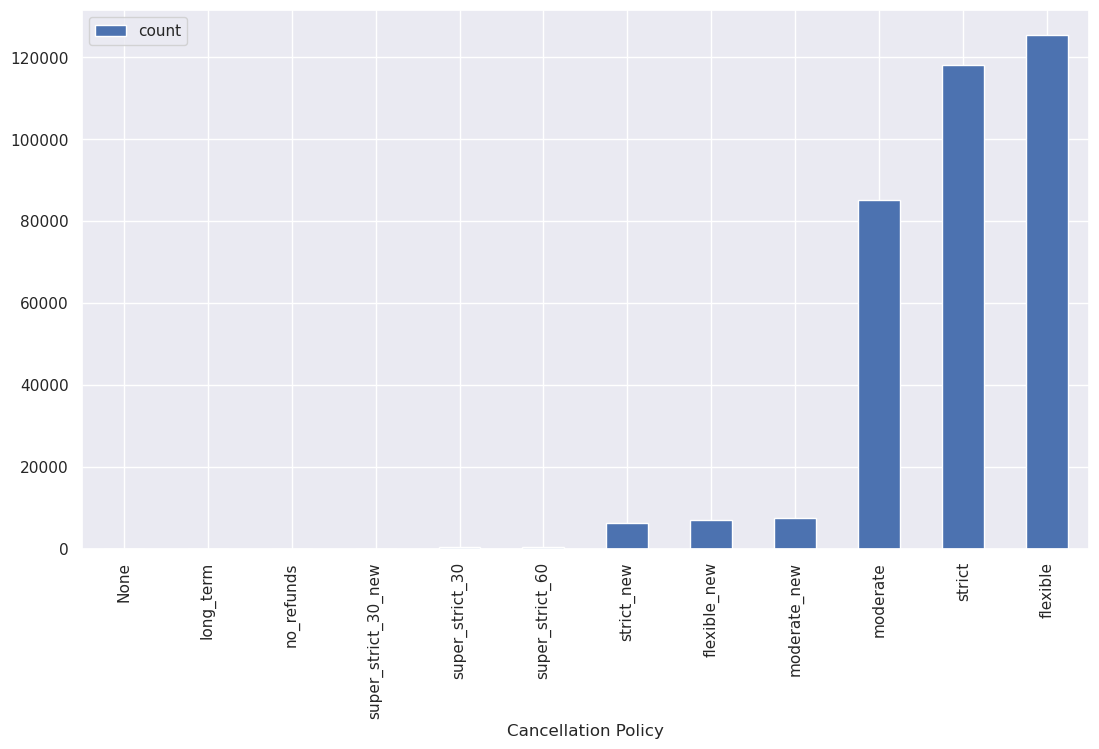

In [44]:
groupField = 'Cancellation Policy'
df.groupBy([groupField]).count().sort('count').toPandas().set_index(groupField).plot(kind='bar', y='count')

<AxesSubplot:xlabel='Room Type,Cancellation Policy'>

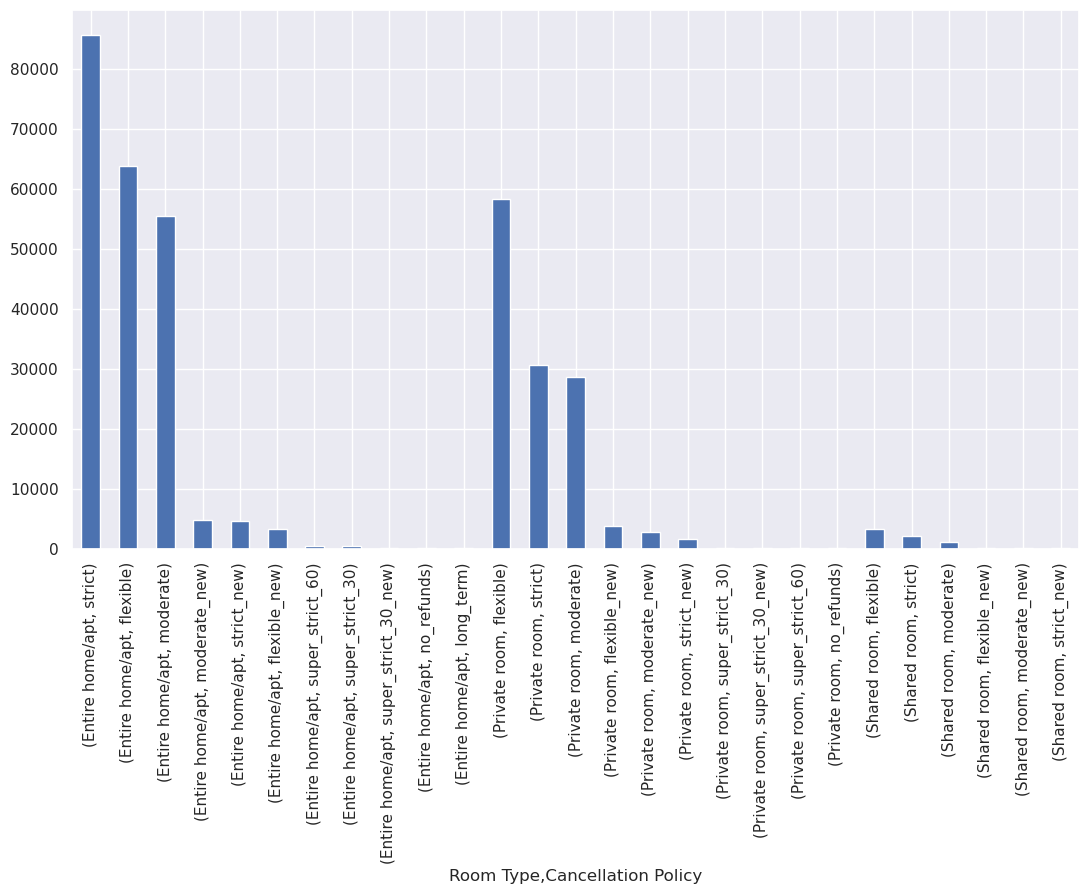

In [45]:
df.select('Room Type', 'Cancellation Policy').toPandas().groupby('Room Type').value_counts().plot(kind='bar')

### Accommodates

<AxesSubplot:ylabel='Frequency'>

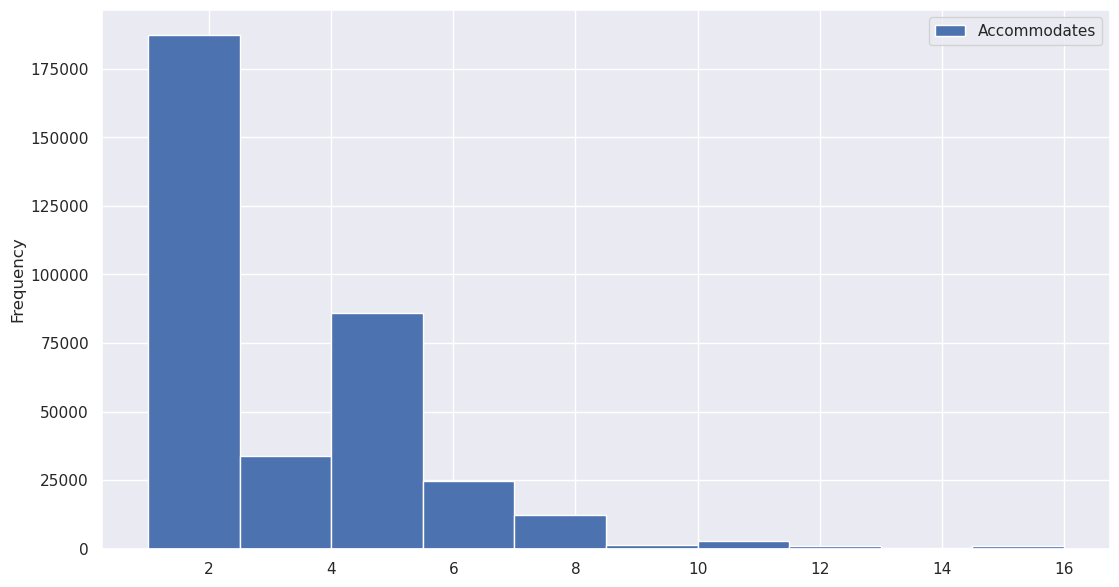

In [46]:
df = df.withColumn('Accommodates', df.Accommodates.cast('int'))
df.select('Accommodates').toPandas().plot(kind='hist')

<AxesSubplot:xlabel='Accommodates', ylabel='Price'>

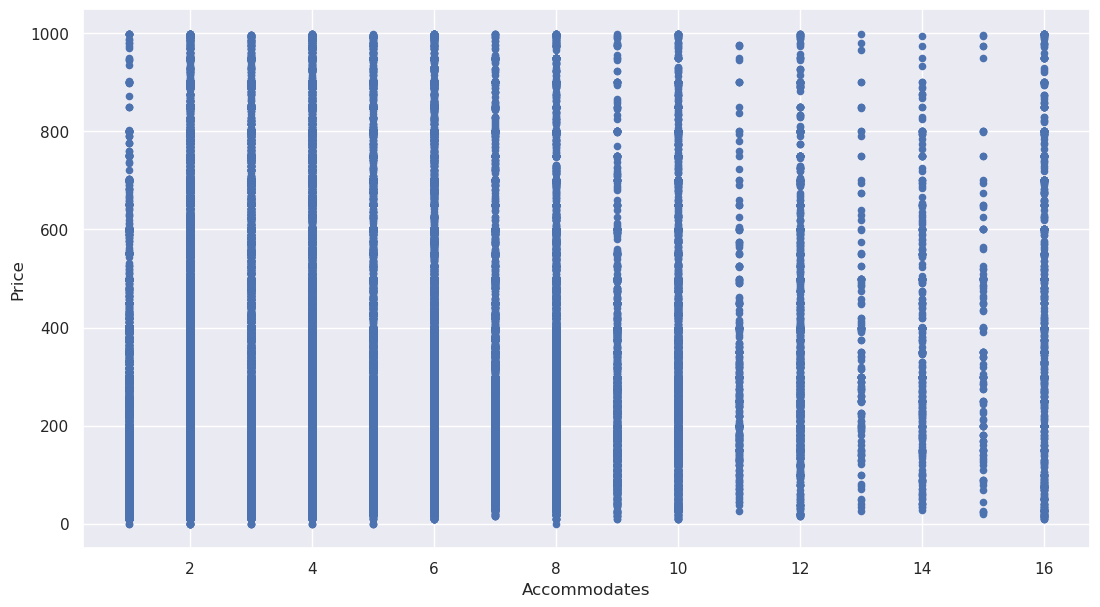

In [47]:
df.select('Price', 'Accommodates').toPandas().plot(kind='scatter', x='Accommodates', y='Price', legend=True)

<AxesSubplot:xlabel='Beds', ylabel='Accommodates'>

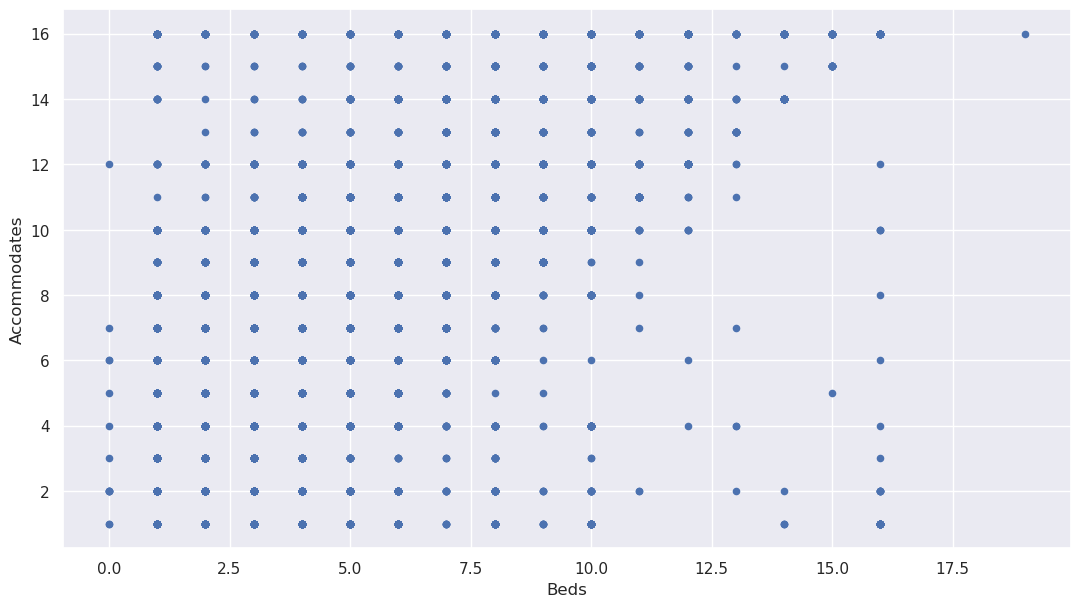

In [48]:
df.select('Accommodates', 'Beds').toPandas().plot(kind='scatter', x='Beds', y='Accommodates', legend=True)

In [49]:
df.describe('Beds').show()

+-------+------------------+
|summary|              Beds|
+-------+------------------+
|  count|            350305|
|   mean|1.8580522687372432|
| stddev|1.3920258385724245|
|    min|                 0|
|    max|                19|
+-------+------------------+



In [50]:
df.filter((df.Beds < 3) & (df.Accommodates > 10)).select('Name', 'Accommodates', 'Room Type', 'Price', 'Bedrooms', 'Beds').show(vertical=True, truncate=False)

-RECORD 0----------------------------------------------------------
 Name         | Beverly Hills oasis for events                     
 Accommodates | 16                                                 
 Room Type    | Entire home/apt                                    
 Price        | 600                                                
 Bedrooms     | 0                                                  
 Beds         | 1                                                  
-RECORD 1----------------------------------------------------------
 Name         | My Other Office: Conference Room                   
 Accommodates | 16                                                 
 Room Type    | Private room                                       
 Price        | 520                                                
 Bedrooms     | 1                                                  
 Beds         | 1                                                  
-RECORD 2---------------------------------------

## Reviews

<AxesSubplot:ylabel='Density'>

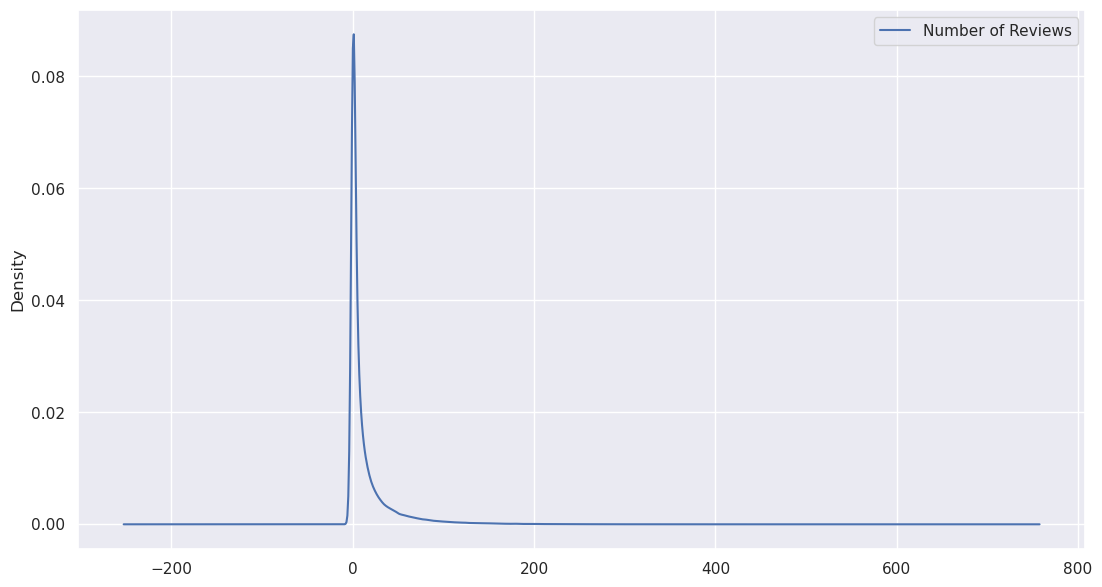

In [51]:
col = 'Number of Reviews'
df = df.withColumn(col, df[col].cast('float'))
df.select(col).toPandas().plot(kind='density')

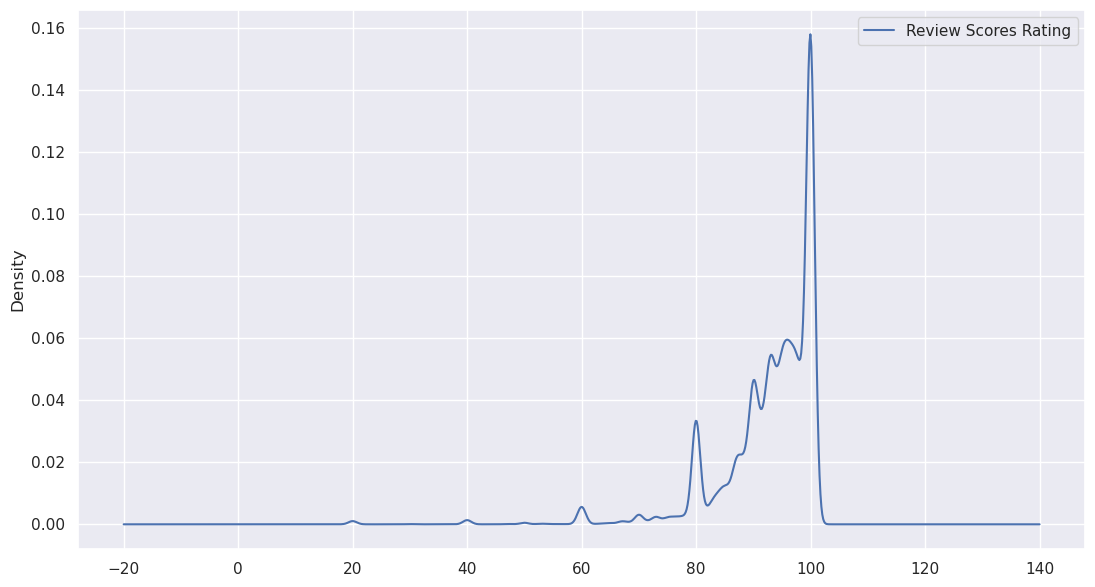

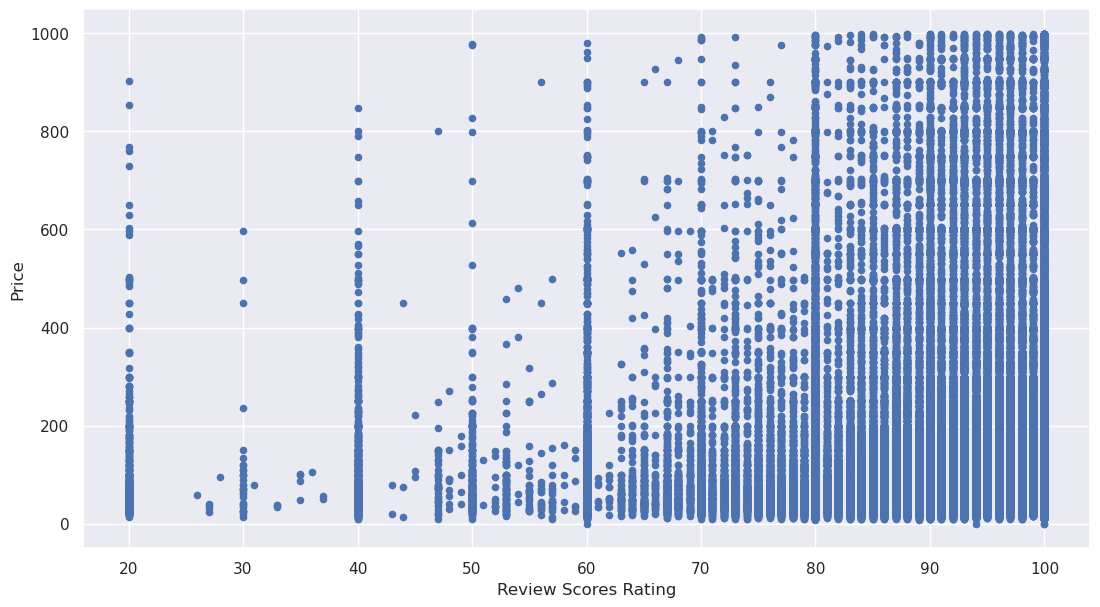

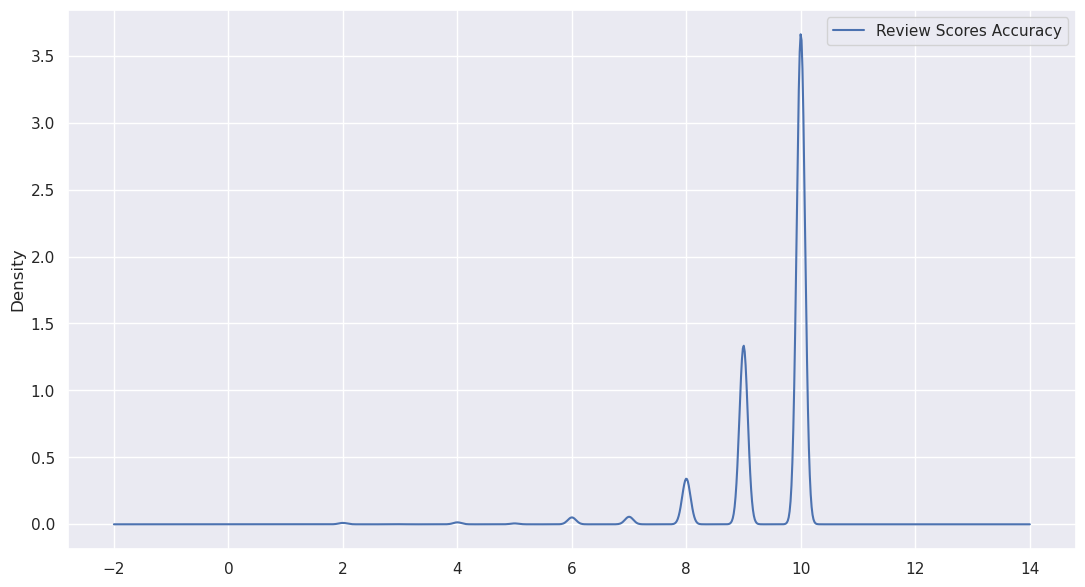

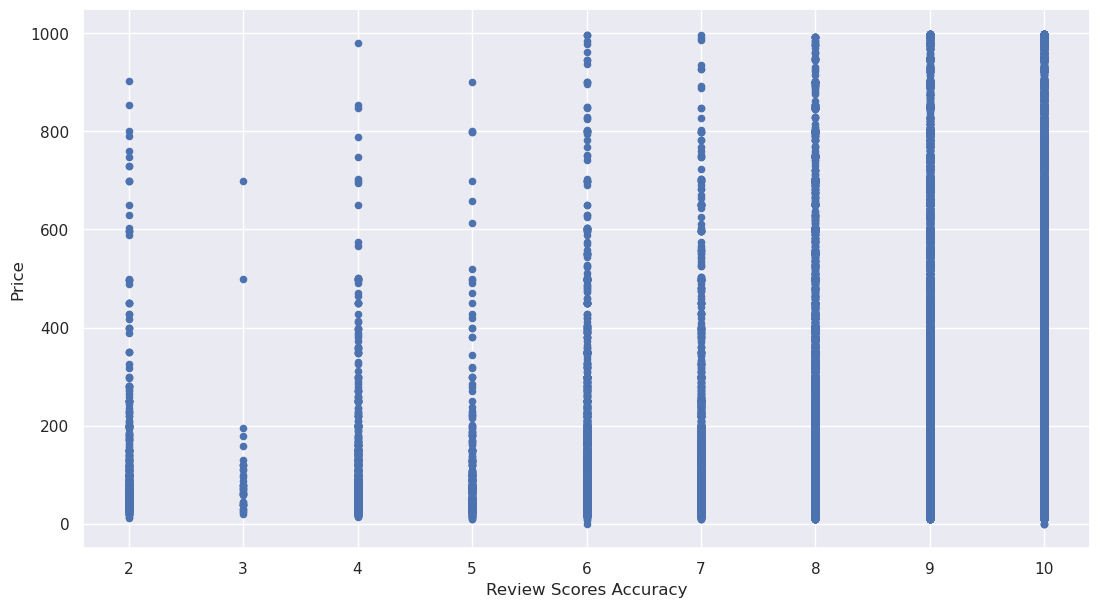

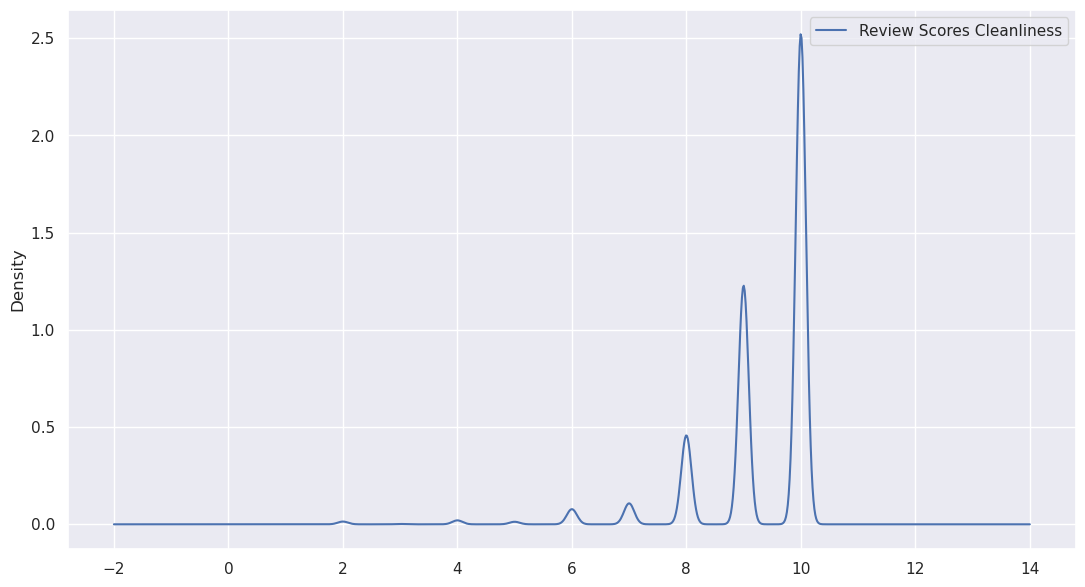

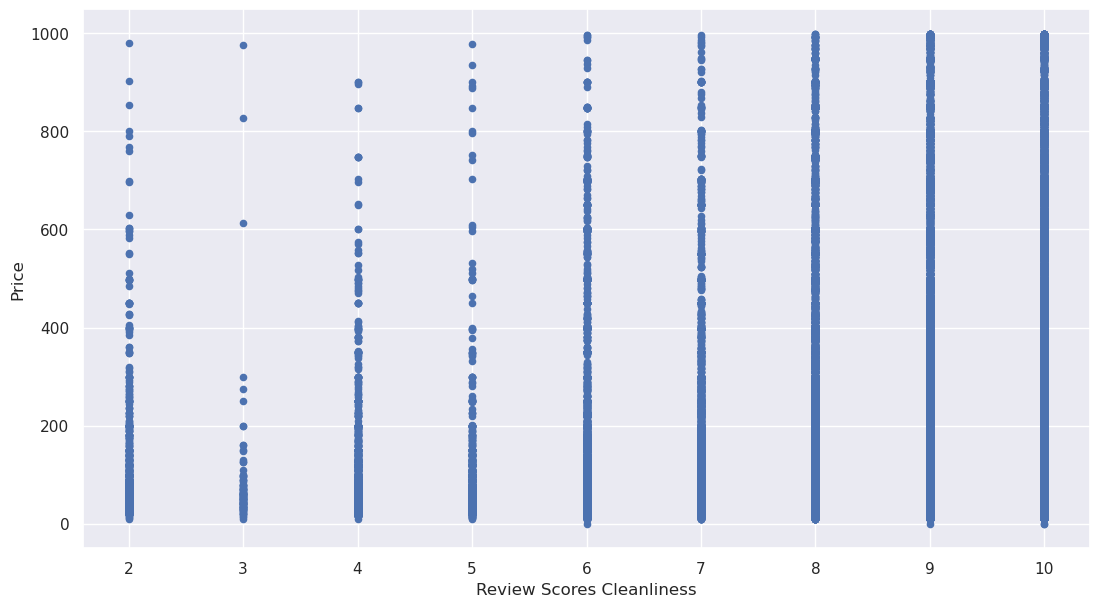

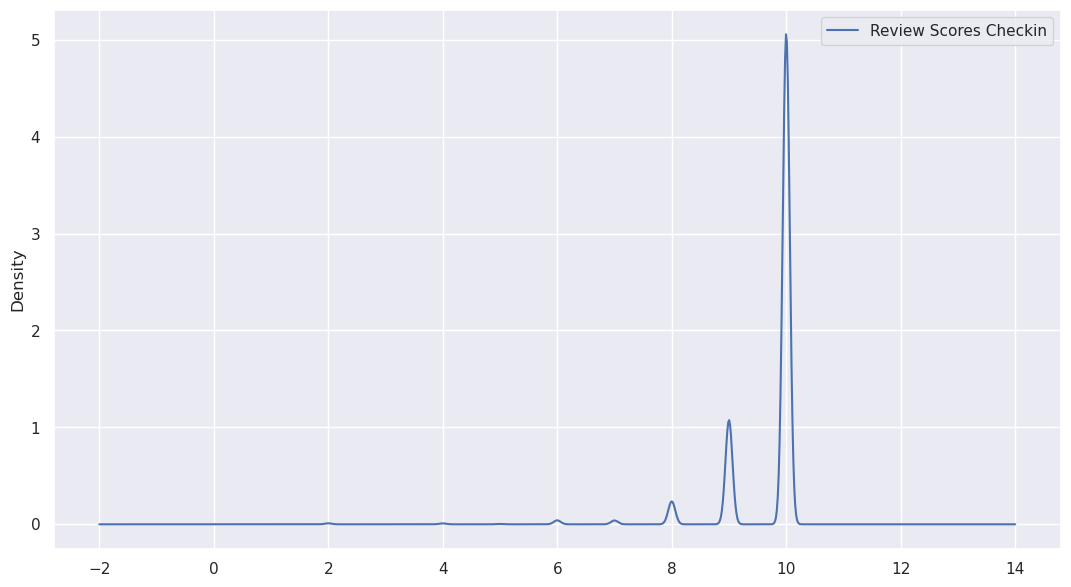

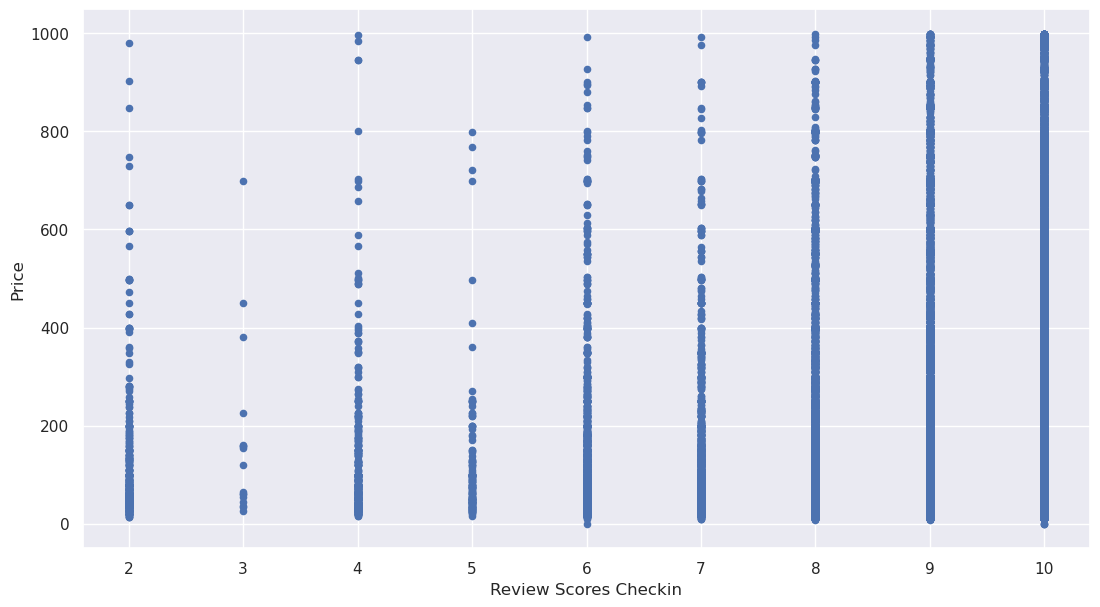

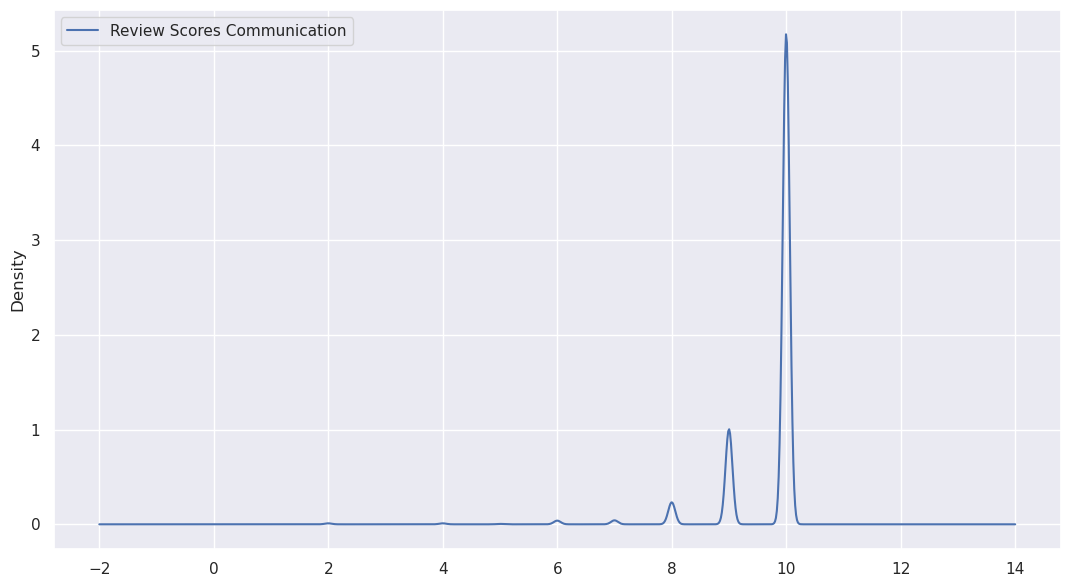

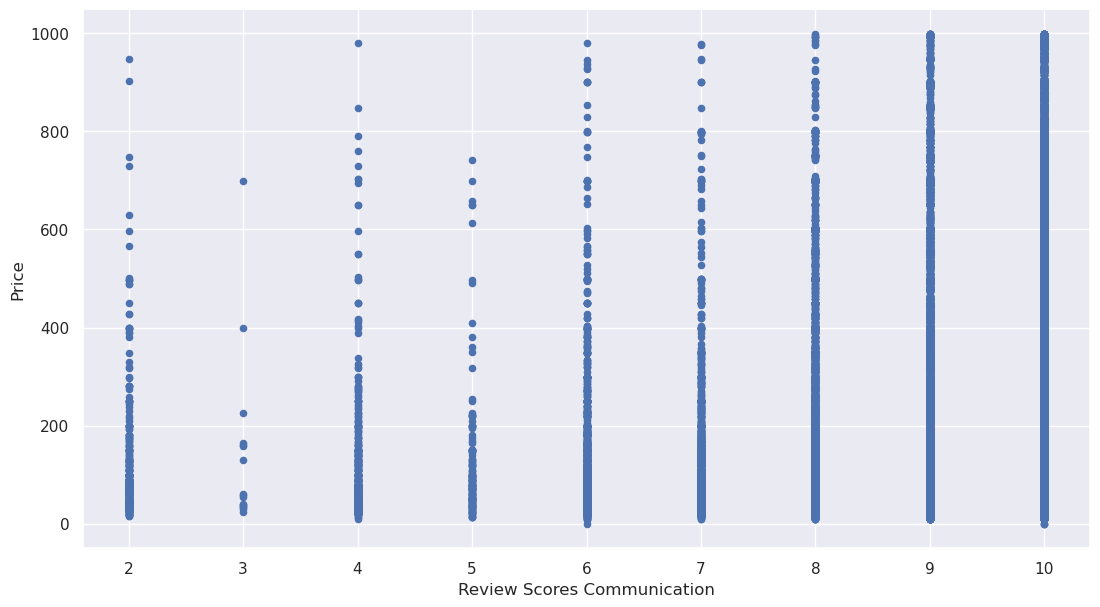

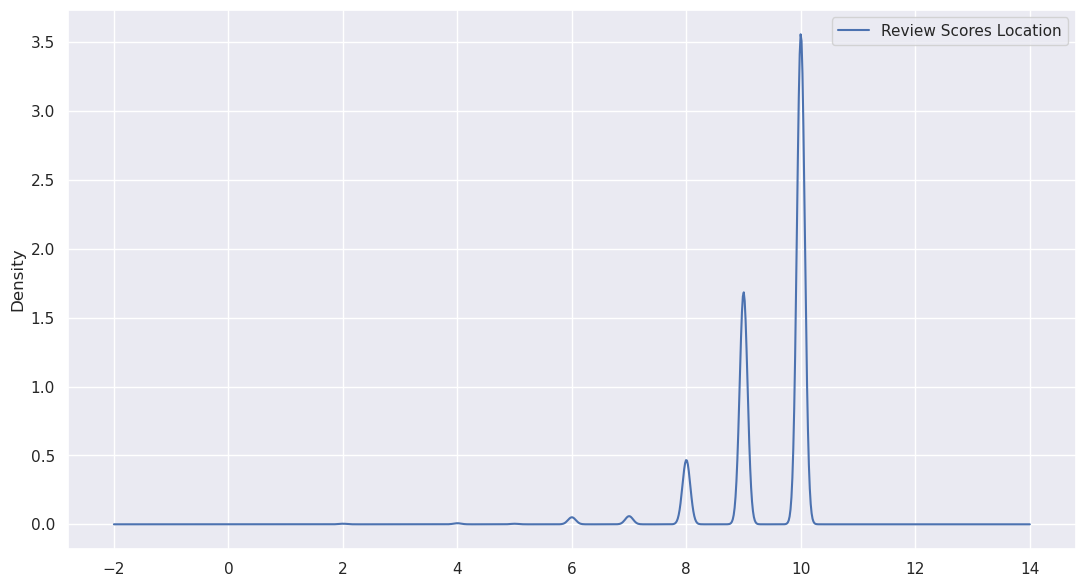

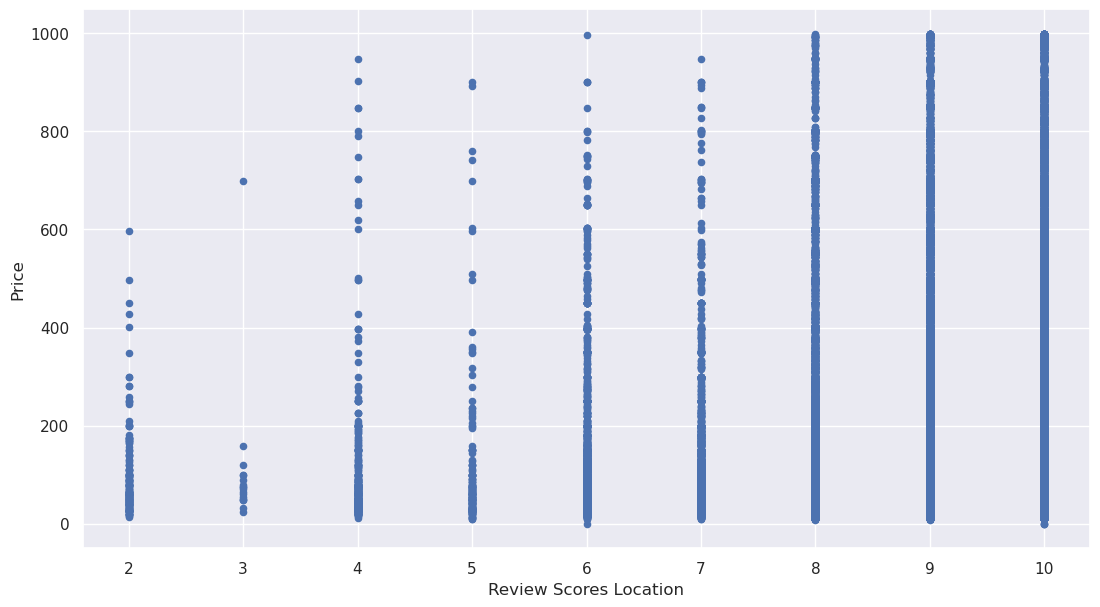

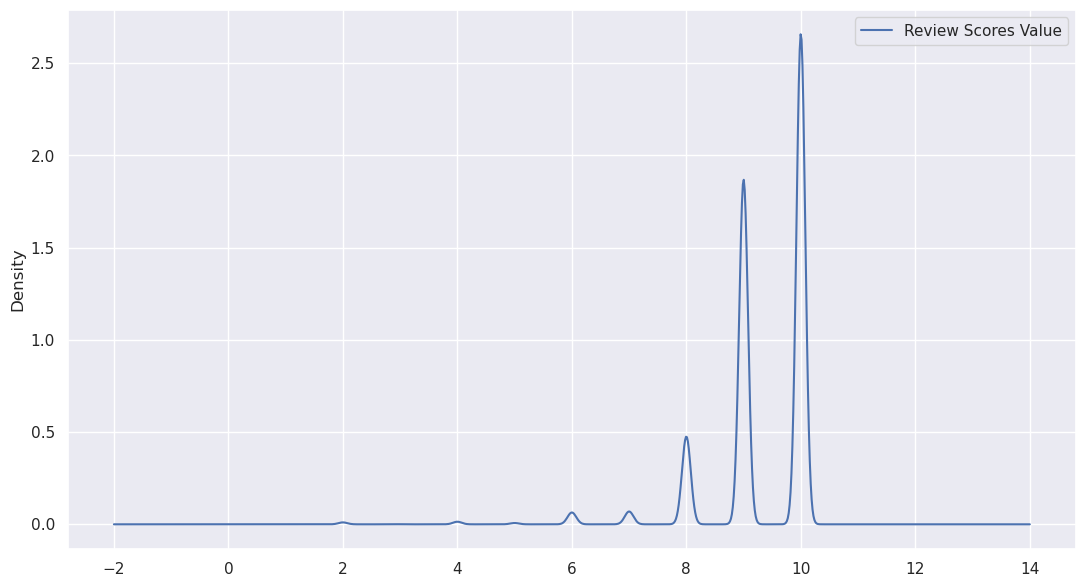

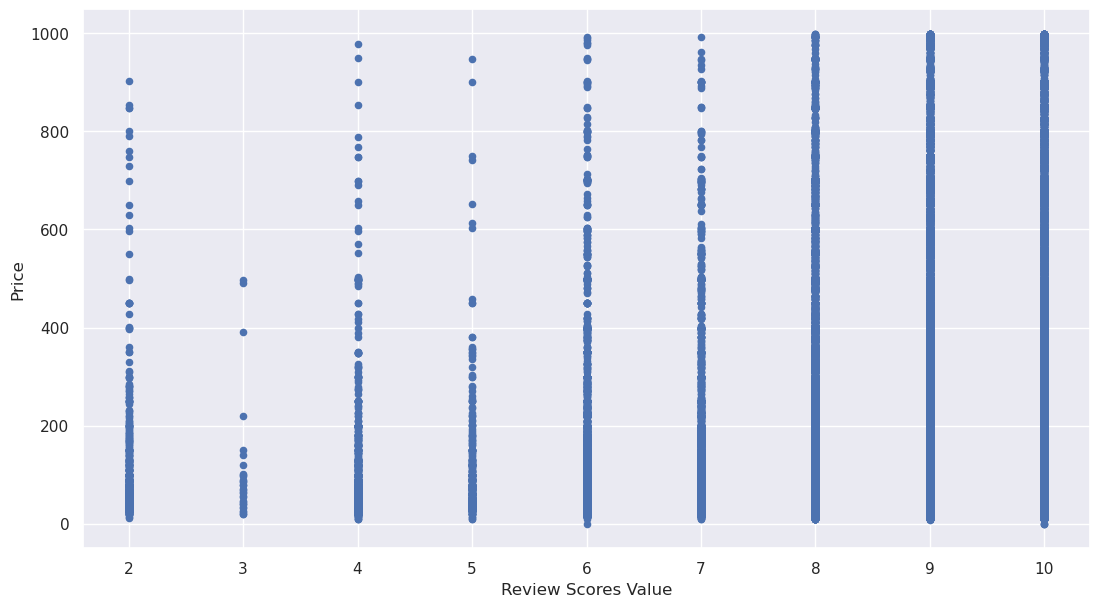

In [52]:
cols = ['Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value']

for col in cols:
    df = df.withColumn(col, df[col].cast('float'))
    df.select(col).toPandas().plot(kind='density')
    df.select(col, 'Price').toPandas().plot(kind='scatter', x=col, y='Price', legend=True)

# **Price Prediction**

#### Qua quá trình exploration phía trên, ta chọn lọc ra những field có ý nghĩa để build mô hình học máy
#### Ex: Bathrooms và Bedrooms tỷ lệ thuận với nhau như đã phân tích, nên ta chỉ cần chọn Bedrooms cho mô hình học

In [54]:
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import MaxAbsScaler

### 'Room Type', 'Cancellation Policy', 'Country', 'City' là những cột có giá trị định tính (categorical).
### Nên ta đưa về dạng vector OneHotEncoding

In [55]:
filteredDf = df['ID', 'Room Type', 'Bedrooms', 'Beds', 'Cancellation Policy', 'Country', 'City', 'Price']
filteredDf = filteredDf.filter(filteredDf['Cancellation Policy'].isNotNull() & filteredDf['Bedrooms'].isNotNull() & filteredDf['Beds'].isNotNull())
cat_cols = ['Room Type', 'Cancellation Policy', 'Country', 'City']
indexers = [StringIndexer(inputCol= c, outputCol= c + "_ind") for c in cat_cols]
encoders = [OneHotEncoder(inputCol= c+"_ind", outputCol= c+ "_one_hot") for c in cat_cols]
pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(filteredDf).transform(filteredDf)

In [56]:
filteredDf.count()

350304

In [57]:
df_encoded.show()

+--------+---------------+--------+----+-------------------+-----------+---------+-----+-------------+-----------------------+-----------+--------+-----------------+---------------------------+---------------+----------------+
|      ID|      Room Type|Bedrooms|Beds|Cancellation Policy|    Country|     City|Price|Room Type_ind|Cancellation Policy_ind|Country_ind|City_ind|Room Type_one_hot|Cancellation Policy_one_hot|Country_one_hot|    City_one_hot|
+--------+---------------+--------+----+-------------------+-----------+---------+-----+-------------+-----------------------+-----------+--------+-----------------+---------------------------+---------------+----------------+
| 8264596|Entire home/apt|       2|   2|           flexible|Netherlands|Amsterdam|  125|          0.0|                    0.0|        9.0|     8.0|    (2,[0],[1.0])|             (10,[0],[1.0])| (19,[9],[1.0])|(4626,[8],[1.0])|
| 2180729|Entire home/apt|       2|   4|           flexible|Netherlands|Amsterdam|  130|    

In [58]:
df_vectorized = df_encoded.drop(*cat_cols, *[c + '_ind' for c in cat_cols])

In [59]:
df_vectorized.columns

['ID',
 'Bedrooms',
 'Beds',
 'Price',
 'Room Type_one_hot',
 'Cancellation Policy_one_hot',
 'Country_one_hot',
 'City_one_hot']

In [60]:
assembler = VectorAssembler(
    inputCols=[col for col in df_vectorized.columns if col not in ['ID', 'Price']],
    outputCol="features")
df_vectorized = assembler.transform(df_vectorized).select(['ID', 'features', 'Price'])
df_vectorized.head()

Row(ID='8264596', features=SparseVector(4659, {0: 2.0, 1: 2.0, 2: 1.0, 4: 1.0, 23: 1.0, 41: 1.0}), Price=125)

In [61]:
scaler = MaxAbsScaler(inputCol='features', outputCol='features_scaled')
df_vectorized = scaler.fit(df_vectorized).transform(df_vectorized)

In [62]:
df_vectorized.show()

+--------+--------------------+-----+--------------------+
|      ID|            features|Price|     features_scaled|
+--------+--------------------+-----+--------------------+
| 8264596|(4659,[0,1,2,4,23...|  125|(4659,[0,1,2,4,23...|
| 2180729|(4659,[0,1,2,4,23...|  130|(4659,[0,1,2,4,23...|
|14463171|(4659,[1,2,6,23,4...|   80|(4659,[1,2,6,23,4...|
|13932749|(4659,[0,1,2,5,23...|  150|(4659,[0,1,2,5,23...|
| 1838958|(4659,[0,1,2,5,23...|  144|(4659,[0,1,2,5,23...|
| 7969792|(4659,[0,1,3,6,23...|   75|(4659,[0,1,3,6,23...|
|14434300|(4659,[0,1,2,4,23...|   59|(4659,[0,1,2,4,23...|
|10590761|(4659,[0,1,2,5,23...|  200|(4659,[0,1,2,5,23...|
| 6981991|(4659,[0,1,2,6,23...|  134|(4659,[0,1,2,6,23...|
|17820658|(4659,[1,3,4,23,4...|   99|(4659,[1,3,4,23,4...|
| 1541068|(4659,[0,1,2,5,23...|  144|(4659,[0,1,2,5,23...|
|12845692|(4659,[0,1,2,5,23...|  114|(4659,[0,1,2,5,23...|
| 6427437|(4659,[0,1,2,5,23...|  125|(4659,[0,1,2,5,23...|
| 9672251|(4659,[0,1,2,5,23...|  175|(4659,[0,1,2,5,23..

In [63]:
from pyspark.ml.feature import ChiSqSelector

selector = ChiSqSelector(numTopFeatures=150, featuresCol="features_scaled",
                         outputCol="features_selected", labelCol="Price")

df_vectorized = selector.fit(df_vectorized).transform(df_vectorized)

In [64]:
df_vectorized.show()

+--------+--------------------+-----+--------------------+--------------------+
|      ID|            features|Price|     features_scaled|   features_selected|
+--------+--------------------+-----+--------------------+--------------------+
| 8264596|(4659,[0,1,2,4,23...|  125|(4659,[0,1,2,4,23...|(150,[0,1,2,4,21,...|
| 2180729|(4659,[0,1,2,4,23...|  130|(4659,[0,1,2,4,23...|(150,[0,1,2,4,21,...|
|14463171|(4659,[1,2,6,23,4...|   80|(4659,[1,2,6,23,4...|(150,[1,2,6,21,37...|
|13932749|(4659,[0,1,2,5,23...|  150|(4659,[0,1,2,5,23...|(150,[0,1,2,5,21,...|
| 1838958|(4659,[0,1,2,5,23...|  144|(4659,[0,1,2,5,23...|(150,[0,1,2,5,21,...|
| 7969792|(4659,[0,1,3,6,23...|   75|(4659,[0,1,3,6,23...|(150,[0,1,3,6,21,...|
|14434300|(4659,[0,1,2,4,23...|   59|(4659,[0,1,2,4,23...|(150,[0,1,2,4,21,...|
|10590761|(4659,[0,1,2,5,23...|  200|(4659,[0,1,2,5,23...|(150,[0,1,2,5,21,...|
| 6981991|(4659,[0,1,2,6,23...|  134|(4659,[0,1,2,6,23...|(150,[0,1,2,6,21,...|
|17820658|(4659,[1,3,4,23,4...|   99|(46

In [65]:
from pyspark.ml.feature import PCA
pca_model = PCA(k=100,inputCol = "features_scaled", outputCol = "pca_features")
df_vectorized = pca_model.fit(df_vectorized).transform(df_vectorized)

In [66]:
from pyspark.ml.feature import PolynomialExpansion

px = PolynomialExpansion(degree=2, inputCol='features_scaled', outputCol='poly_features')
df_vectorized = px.transform(df_vectorized)

In [67]:
train_df, test_df = df_vectorized.randomSplit([0.8, 0.2])
train_df.count(), test_df.count()

(280351, 69953)

In [68]:
def train_and_evaluate(dt, train_df, test_df):
    dt_model = dt.fit(train_df)
    dt_train_pred = dt_model.transform(train_df)
    dt_test_pred = dt_model.transform(test_df)
    dt_evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction")
    rmse_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "rmse"})
    mae_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "mae"})
    r2_train = dt_evaluator.evaluate(dt_train_pred, {dt_evaluator.metricName: "r2"})

    rmse_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "rmse"})
    mae_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "mae"})    
    r2_test = dt_evaluator.evaluate(dt_test_pred, {dt_evaluator.metricName: "r2"})

    print("RMSE on train data = %g" % rmse_train)
    print("MAE on train data = %g" % mae_train)
    print("R2 on train data = %g" % r2_train)

    print("RMSE on test data = %g" % rmse_test)
    print("MAE on test data = %g" % mae_test)
    print("R2 on test data = %g" % r2_test)

    return dt_model


In [69]:
lr = LinearRegression(maxIter=100, labelCol='Price', featuresCol='features')
lr_model = train_and_evaluate(lr, train_df, test_df)

RMSE on train data = 87.3975
MAE on train data = 52.1859
R2 on train data = 0.672928
RMSE on test data = 89.6799
MAE on test data = 53.5349
R2 on test data = 0.653346


<AxesSubplot:ylabel='feature'>

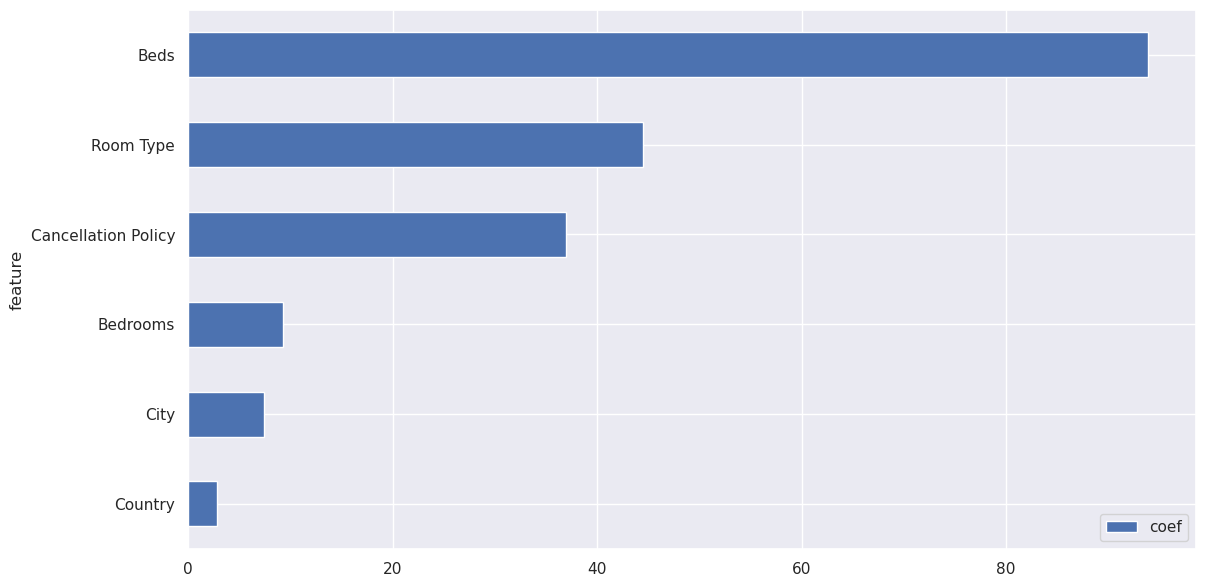

In [70]:
import pandas as pd
df_cols = ['Room Type', 'Bedrooms', 'Beds', 'Cancellation Policy', 'Country', 'City']
coefs = lr_model.coefficients
feature_importances = pd.DataFrame(sorted(list(zip(df_cols, coefs[:len(df_cols)])), key=lambda x: abs(x[1]), reverse=False), columns=['feature', 'coef'])
feature_importances.plot.barh(x='feature')

In [71]:
lr = LinearRegression(maxIter=100, labelCol='Price', featuresCol='features_selected')
lr_model = train_and_evaluate(lr, train_df, test_df)

RMSE on train data = 89.0682
MAE on train data = 53.3455
R2 on train data = 0.660303
RMSE on test data = 90.112
MAE on test data = 53.7386
R2 on test data = 0.649997


In [72]:
lr = LinearRegression(maxIter=100, labelCol='Price', featuresCol='pca_features')
lr_model = train_and_evaluate(lr, train_df, test_df)

RMSE on train data = 89.6291
MAE on train data = 53.7582
R2 on train data = 0.656012
RMSE on test data = 90.6053
MAE on test data = 54.1332
R2 on test data = 0.646154


<AxesSubplot:ylabel='feature'>

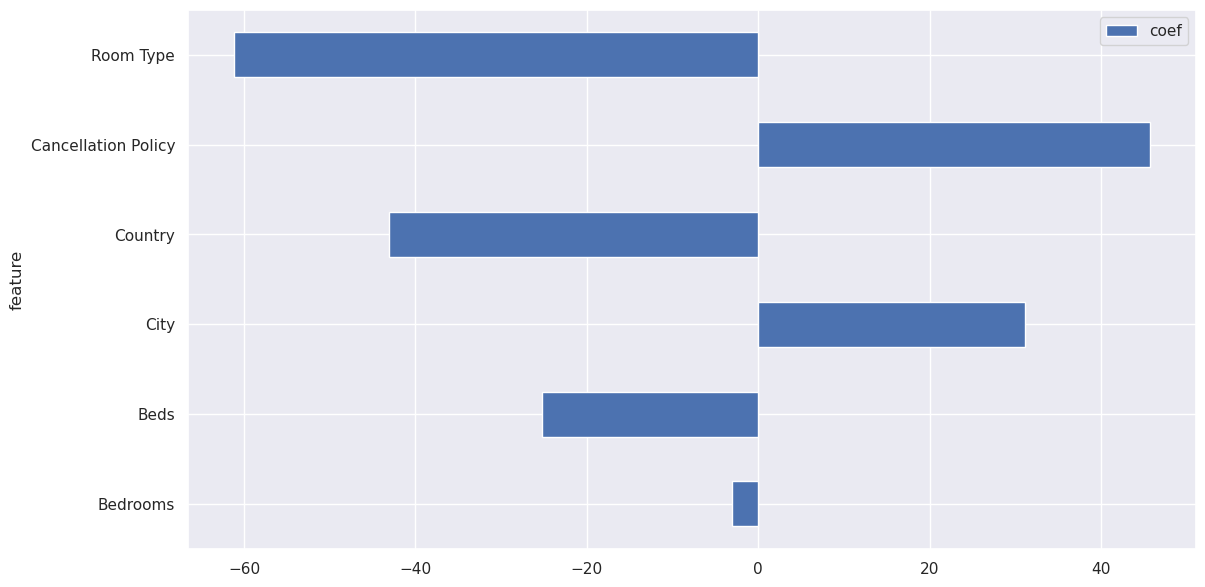

In [73]:
import pandas as pd
df_cols = ['Room Type', 'Bedrooms', 'Beds', 'Cancellation Policy', 'Country', 'City']
coefs = lr_model.coefficients
feature_importances = pd.DataFrame(sorted(list(zip(df_cols, coefs[:len(df_cols)])), key=lambda x: abs(x[1]), reverse=False), columns=['feature', 'coef'])
feature_importances.plot.barh(x='feature')

In [74]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Price', maxDepth=10)
train_and_evaluate(dt, train_df, test_df)

RMSE on train data = 84.0079
MAE on train data = 48.7118
R2 on train data = 0.697806
RMSE on test data = 86.4701
MAE on test data = 49.5
R2 on test data = 0.677716


DecisionTreeRegressionModel: uid=DecisionTreeRegressor_fedc4bd53b52, depth=10, numNodes=1091, numFeatures=4659

In [75]:
dt = DecisionTreeRegressor(featuresCol ='features_scaled', labelCol = 'Price', maxDepth=10)
train_and_evaluate(dt, train_df, test_df)

RMSE on train data = 84.0768
MAE on train data = 48.7084
R2 on train data = 0.69731
RMSE on test data = 86.3527
MAE on test data = 49.4576
R2 on test data = 0.678591


DecisionTreeRegressionModel: uid=DecisionTreeRegressor_b95521f7a644, depth=10, numNodes=1151, numFeatures=4659